In [30]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_dataset
from src.models import Net, ConvBlock, LinearBlock
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.nn_train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.sklearn_train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn

from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

RESDIR='../output/train_eval/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


# datasets reload / re-save (for nnalign & prime)

In [2]:
# Datasets
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_viral = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)

In [3]:
prime.StudyOrigin.unique()

array(['Bobisse', 'Bassani-Sternberg', 'Bentzen', 'Cohen', 'Stronen',
       'Kalaora', 'McGrannahan', 'van Rooij', 'Rajasagi', 'Rizvi',
       'Robbins', 'Snyder', 'Wick', 'Sahin', 'Ott', 'Bulik-Sullivan',
       'Dengue', 'Calis', 'Random'], dtype=object)

In [4]:
# Saving for nnalign
cedar[['Peptide', 'agg_label']].to_csv('../../../nnalign/partitioned_data/cedar.pep', index=False,header=False, sep='\t')
cedar_hp_low[['Peptide', 'agg_label']].to_csv('../../../nnalign/partitioned_data/cedar_hp_low.pep', index=False,header=False, sep='\t')
cedar_hp_uni[['Peptide', 'agg_label']].to_csv('../../../nnalign/partitioned_data/cedar_hp_uni.pep', index=False,header=False, sep='\t')
cedar_viral[['Peptide', 'agg_label']].to_csv('../../../nnalign/partitioned_data/cedar_viral.pep', index=False,header=False, sep='\t')
prime[['Mutant', 'Immunogenicity']].to_csv('../../../nnalign/partitioned_data/prime.pep', index=False,header=False, sep='\t')

In [5]:
# Saving for PRIME
cedar[['Peptide']].to_csv('../../../gfeller_tools/PRIME/data/cedar.pep', index=False,header=False)
cedar_hp_low[['Peptide']].to_csv('../../../gfeller_tools/PRIME/data/cedar_hp_low.pep', index=False,header=False)
cedar_hp_uni[['Peptide']].to_csv('../../../gfeller_tools/PRIME/data/cedar_hp_uni.pep', index=False,header=False)
cedar_viral[['Peptide']].to_csv('../../../gfeller_tools/PRIME/data/cedar_viral.pep', index=False,header=False)
prime[['Mutant']].to_csv('../../../gfeller_tools/PRIME/data/prime.pep', index=False,header=False)

### Make prime KCV partitioning

In [141]:
prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)

In [189]:
xp = prime.reset_index(drop=True).rename(columns={'Immunogenicity':'agg_label',
                                               'Mutant':'Peptide', 'Allele':'HLA',
                                                'NetMHCpanEL':'trueHLA_EL_rank'})

In [197]:
from src.partition_tools import *
prime_fold = pipeline_stratified_kfold('../../../kern_dist/out/prime.pep_0.85.pep', 
                          prime.sort_values('Mutant',ascending=True).reset_index(drop=True).rename(columns={'Immunogenicity':'agg_label',
                                               'Mutant':'Peptide', 'Allele':'HLA',
                                                'NetMHCpanEL':'trueHLA_EL_rank'}), 
                          k=5, shuffle=True)
len(prime), len(prime_fold)

(7758, 7758)

In [199]:
prime_fold.to_csv('../data/partitioned_traindata/prime_5fold.csv')

### Retry training XGBoost with more depth etc.

In [222]:
from src.sklearn_train_eval import nested_kcv_train_sklearn, evaluate_trained_models_sklearn
from src.data_processing import BL62_VALUES
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')
ics_none = None
train_dataset = cedar
# Flatten the list of products
# Gets the argument in the order :
# train_dataset, encoding, blosum matrix, ics dict, ics name, mask, add rank, add prop, remove pep, standardize
cedar_peps = cedar.Peptide.values

prime_dataset = prime.query('StudyOrigin!="Random" and Mutant not in @cedar_peps')
    # RENAME COLUMNS to avoid re-creating a custom prime kwargs every in function call
prime_dataset.rename(columns={'Mutant': 'Peptide', 'Allele': 'HLA',
                              'Immunogenicity': 'agg_label', 'NetMHCpanEL': 'trueHLA_EL_rank'},
                     inplace=True)
res = {}
for encoding in ['onehot','blosum']:
    blosum_matrix = BL62_VALUES if encoding == 'blosum' else None
    
    for ics, name in zip([ics_kl, ics_shannon, ics_none], ['KL', 'Shannon', 'None']):
        for depth in [3,7,None]:
            model = XGBClassifier(method='gpu_hist', n_estimators=250, max_depth=depth, learning_rate=0.1, n_jobs=-1, verbosity = 0)
            encoding_kwargs = {'max_len': 12,
                           'encoding': encoding,
                           'blosum_matrix': blosum_matrix,
                           'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                           'add_rank': True,
                           'add_aaprop': False,
                           'remove_pep': False,
                           'standardize': True}
            # Here sets the output tag (names, variables and their values)
            # quickly rename the model name so it's shorter
            mapping = {'RandomForestClassifier': 'RF',
                       'LogisticRegression': 'LogReg',
                       'XGBClassifier': 'XGB',
                       'FFN': 'FFN'}
            # Save the parameter name as a massive string to tag the output.
            # Set the "trainset" name in the beginning of the for loop by assigning name to a train_dataset column
            # i.e. train_dataset['trainset'] = 'name'

            outname = '_'.join([encoding, name, str(depth)])
            
            models_dict, train_metrics, test_metrics = nested_kcv_train_sklearn(cedar, model, ics, encoding_kwargs)
            cedar_results = evaluate_trained_models_sklearn(cedar, models_dict, ics, cedar,
                                                            train_metrics, encoding_kwargs=encoding_kwargs,
                                                            concatenated=True)

            prime_results = evaluate_trained_models_sklearn(prime_dataset, models_dict, ics,
                                                            train_metrics=train_metrics,
                                                            encoding_kwargs=encoding_kwargs, concatenated=True)
            res[outname] = [models_dict, train_metrics, cedar_results, prime_results]


Outer fold: 100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:44<00:00,  4.41s/it]


In [225]:
pkl_dump(res, 'tmp.pkl')

tmp.pkl saved.


In [237]:
res['onehot_KL_None'][2]['concatenated']['auc']

0.7066945246314932

# baselines (loading nnalign results, prime results)

## save/load

In [9]:
# nn align
nndir = '../../../nnalign/partitioned_output/_old/'
nnalign_cedar = pd.read_csv(f'{nndir}cedar.pep_39077/cedar.pep_39077.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_low = pd.read_csv(f'{nndir}cedar_hp_low.pep_34256/cedar_hp_low.pep_34256.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_uni = pd.read_csv(f'{nndir}cedar_hp_uni.pep_28097/cedar_hp_uni.pep_28097.lg6.sorted.pred', sep = '\t')
nnalign_cedar_viral = pd.read_csv(f'{nndir}cedar_viral.pep_2684/cedar_viral.pep_2684.lg6.sorted.pred', sep = '\t')
nnalign_prime = pd.read_csv(f'{nndir}prime.pep_12391/prime.pep_12391.lg6.sorted.pred', sep = '\t')

In [10]:
# PRIME
primedir='../../../gfeller_tools/PRIME/output/'
prime_cedar = pd.read_csv(f'{primedir}cedar_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_low = pd.read_csv(f'{primedir}cedar_hp_low_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_uni = pd.read_csv(f'{primedir}cedar_hp_uni_PRIME.out', comment = '#', sep = '\t')
prime_cedar_viral = pd.read_csv(f'{primedir}cedar_viral_PRIME.out', comment = '#', sep = '\t')
prime_prime = pd.read_csv(f'{primedir}prime_PRIME.out', comment = '#', sep = '\t')

In [ ]:
display(prime_cedar.head(1))
display(nnalign_cedar.sort_values('Peptide', ascending=True).head(1))
display(cedar.head(1))

## Merging 

In [11]:
import copy
def merging(df, df_nnalign, df_prime):
    df = df.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_nnalign = df_nnalign.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_prime = df_prime.sort_values('Peptide', ascending=True).reset_index(drop=True)
    out = copy.deepcopy(df)
    tmp = df_nnalign.rename(columns={'Prediction':'nnalign_score'}).merge(df_prime.rename(columns={'%Rank_bestAllele':'MixMHCrank',
                                                    'Score_bestAllele':'PRIME_score',
                                                    'BestAllele':'MixMHCallele'})[['Peptide', 'MixMHCrank', 'PRIME_score', 'MixMHCallele']],
                           left_index=True, right_index=True)
    out = out.merge(tmp, left_index=True, right_index=True)
    return out

In [12]:
cedar = merging(cedar, nnalign_cedar, prime_cedar)
cedar_hp_low = merging(cedar_hp_low, nnalign_cedar_hp_low, prime_cedar_hp_low)
cedar_hp_uni = merging(cedar_hp_uni, nnalign_cedar_hp_uni, prime_cedar_hp_uni)
cedar_viral = merging(cedar_viral, nnalign_cedar_viral, prime_cedar_viral)
prime = merging(prime.rename(columns={'Mutant':'Peptide'}), nnalign_prime, prime_prime)

## quick roc check

Text(0.5, 1.0, 'Comparison of baselines for PRIME')

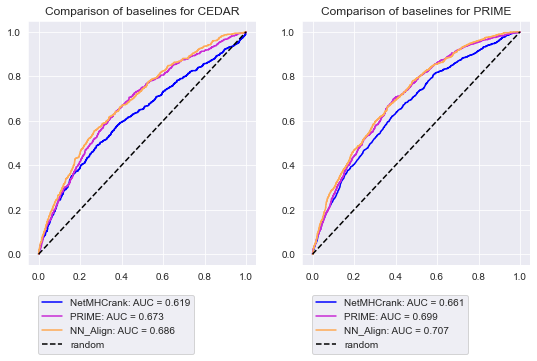

In [13]:
# For CEDAR
from sklearn.metrics import roc_auc_score, roc_curve
#FOR CEDAR
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)

sns.set_palette('gnuplot2', n_colors=3)
f,a = plt.subplots(1,2, figsize=(9,4.5))
a[0].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[0].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[0].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[0].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[0].legend(bbox_to_anchor=(0.75, -0.1))
a[0].set_title('Comparison of baselines for CEDAR')
# FOR PRIME
# EL rank
prime = prime.query('StudyOrigin!="Random"')
fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)
a[1].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[1].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[1].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[1].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[1].legend(bbox_to_anchor=(0.75, -0.1))
a[1].set_title('Comparison of baselines for PRIME')

## BASELINE ROCS

In [14]:
def plot_baseline(axis, dataset):
    if dataset=='cedar':
        fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)
    elif dataset=='prime':
        fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
        auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
        auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
        auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)
    
    axis.plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')


# Results

In [27]:
PAL = sns.color_palette('hsv', n_colors=13)
palette = [PAL[-1], PAL[0], PAL[4], PAL [-4]]

In [15]:
# Pickles with results&curves
cedar_log = pkl_load(f'{RESDIR}run_220826_13h42m44s_logreg/cedar_results_log.pkl')
prime_log = pkl_load(f'{RESDIR}run_220826_13h42m44s_logreg/prime_results_log.pkl')
cedar_rf = pkl_load(f'{RESDIR}run_220826_13h45m05s_rf/cedar_results_rf.pkl')
prime_rf = pkl_load(f'{RESDIR}run_220826_13h45m05s_rf/prime_results_rf.pkl')
cedar_xgb_hp = pkl_load(f'{RESDIR}run_220826_13h42m48s_xgb_hp/cedar_results_xgb_hp.pkl')
prime_xgb_hp = pkl_load(f'{RESDIR}run_220826_13h42m48s_xgb_hp/prime_results_xgb_hp.pkl')
cedar_xgb_normal = pkl_load(f'{RESDIR}run_220826_13h42m49_xgb_normal/cedar_results_xgb_normal.pkl')
prime_xgb_normal = pkl_load(f'{RESDIR}run_220826_13h42m49_xgb_normal/prime_results_xgb_normal.pkl')
cedar_nn = pkl_load(f'{RESDIR}run_220826_13h45m05s_nn/cedar_results_nn.pkl')
prime_nn = pkl_load(f'{RESDIR}run_220826_13h45m05s_nn/prime_results_nn.pkl')

In [16]:
# Dataframes with scores
df_log = pd.read_csv(f'{RESDIR}run_220826_13h42m44s_logreg/df_results_log.csv')
df_rf = pd.read_csv(f'{RESDIR}run_220826_13h45m05s_rf/df_results_rf.csv')
# df_xgb = pd.concat([pd.read_csv(f'{RESDIR}run_220826_13h42m48s_xgb_hp/df_results_xgb_hp.csv'),
                    # pd.read_csv(f'{RESDIR}run_220826_13h42m49_xgb_normal/df_results_xgb_normal.csv')])
df_xgb_hp = pd.read_csv(f'{RESDIR}run_220826_13h42m48s_xgb_hp/df_results_xgb_hp.csv')
df_xgb_normal = pd.read_csv(f'{RESDIR}run_220826_13h42m49_xgb_normal/df_results_xgb_normal.csv')
df_nn = pd.read_csv(f'{RESDIR}run_220826_13h45m05s_nn/df_results_nn.csv')
df = pd.concat([df_log, df_rf, df_xgb_hp, df_xgb_normal, df_nn])

### Checking CEDAR vs PRIME performance scatter

In [24]:
df.query('score_concat_cedar_auc<=0.45').sort_values('score_concat_cedar_auc').tail(100)

,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm,lr,wd
791,cedar_hp_rank_low,FFN,Mask,12,blosum,True,False,True,False,False,0.391877,0.487889,0.000000,0.404670,0.487432,0.000000,0.413183,0.492669,0.000000,0.430910,0.489068,0.000000,0.653770,0.555158,0.000000,BL62LO,0.0010,0.010000
982,cedar_hp_rank_uni,FFN,KL,12,blosum,False,True,True,False,False,0.425032,0.491343,0.000000,0.425152,0.490550,0.000000,0.430376,0.493490,0.000000,0.431191,0.493645,0.000000,0.795578,0.605872,0.000364,BL62FREQ,0.0010,0.000001
77,cedar,FFN,None,12,onehot,False,True,True,True,False,0.392473,0.487371,0.000337,0.419182,0.487199,0.000342,0.413039,0.491103,0.000000,0.431452,0.490535,0.000000,0.609654,0.539941,0.000000,NaN,0.0005,0.010000
55,cedar,FFN,KL,12,onehot,False,False,True,False,False,0.392587,0.487482,0.000171,0.412448,0.487481,0.000171,0.411185,0.490413,0.000000,0.431711,0.490842,0.000000,0.607730,0.533370,0.000000,NaN,0.0010,0.010000
1558,cedar_virus,FFN,None,12,blosum,False,False,True,False,False,0.404602,0.489793,0.000000,0.409165,0.488548,0.000000,0.432356,0.498070,0.000000,0.431789,0.494943,0.000000,0.576142,0.520306,0.000000,BL62LO,0.0010,0.000001
1492,cedar_virus,FFN,Shannon,12,blosum,False,False,True,False,False,0.398292,0.488108,0.000170,0.423287,0.488076,0.000171,0.423844,0.492678,0.000000,0.431813,0.488983,0.000000,0.577843,0.521624,0.000000,BL62LO,0.0005,0.000001
150,cedar,FFN,Shannon,12,blosum,False,True,True,False,False,0.397934,0.487710,0.000000,0.409805,0.487518,0.000000,0.416458,0.489733,0.000000,0.431994,0.490192,0.000000,0.612711,0.540516,0.000000,BL62FREQ,0.0010,0.000001
79,cedar,FFN,None,12,onehot,False,True,True,True,False,0.391899,0.487345,0.000000,0.419389,0.487229,0.000000,0.412582,0.491115,0.000000,0.432045,0.490654,0.000000,0.609770,0.539887,0.000000,NaN,0.0010,0.010000
710,cedar_hp_rank_low,FFN,KL,12,blosum,False,True,True,False,False,0.405715,0.488374,0.000000,0.414496,0.488156,0.000000,0.428392,0.493403,0.000000,0.432075,0.490154,0.000000,0.665377,0.557071,0.000000,BL62LO,0.0010,0.000001
213,cedar,FFN,None,12,blosum,False,True,True,False,False,0.397023,0.487809,0.000000,0.409926,0.487617,0.000000,0.416360,0.489966,0.000000,0.432076,0.488152,0.000000,0.612621,0.540182,0.000000,BL62FREQ,0.0005,0.010000


Text(0.44, 0.4025, 'FFN\nadd_aa_prop==True')

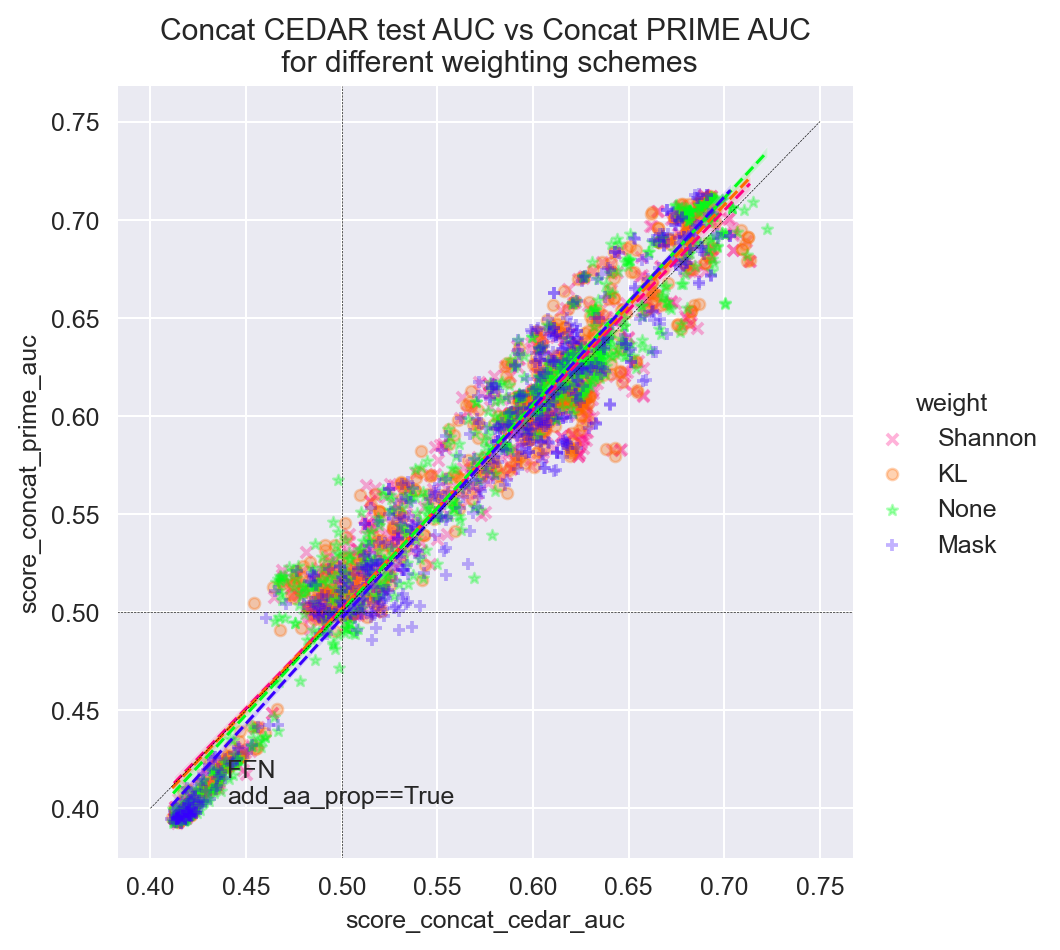

In [34]:
sns.set_palette(palette)
f = plt.Figure(figsize=(7,6))
sns.lmplot(data=df, x = 'score_concat_cedar_auc', y = 'score_concat_prime_auc', hue='weight',
           markers = ['x', 'o', '*', '+'], scatter_kws={"alpha":0.3,"s":20}, line_kws={'lw':1.2,'ls':'--'})

plt.plot([0.4,0.75],[0.4,.75], lw=0.25, ls='--', c='k')
plt.xlim = [0.4, 0.75]
plt.ylim = [0.4, 0.75]
plt.title('Concat CEDAR test AUC vs Concat PRIME AUC\n for different weighting schemes')
plt.axvline(x=0.5, ls='--', c='k', lw=0.25)
plt.axhline(y=0.5, ls='--', c='k', lw=0.25)
plt.text(x=0.44, y=0.4025, s='FFN\nadd_aa_prop==True')

## check top values

In [17]:
print(f"\n{'df_log'.upper()}")
display(df_log.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_log.sort_values('score_avg_valid_auc',ascending=False).head(3))

print(f"\n{'df_rf'.upper()}")
display(df_rf.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_rf.sort_values('score_avg_valid_auc',ascending=False).head(3))

print(f"\n{'df_xgb_hp'.upper()}")
display(df_xgb_hp.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_xgb_hp.sort_values('score_avg_valid_auc',ascending=False).head(3))

print(f"\n{'df_xgb_normal'.upper()}")
display(df_xgb_normal.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_xgb_normal.sort_values('score_avg_valid_auc',ascending=False).head(3))

print(f"\n{'df_nn'.upper()}")
display(df_nn.sort_values('score_avg_cedar_auc',ascending=False).head(3))
display(df_nn.sort_values('score_avg_valid_auc',ascending=False).head(3))



DF_LOG


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
40,cedar,LogReg,Shannon,12,blosum,False,False,True,False,True,0.610389,0.518516,0.015553,0.610378,0.518468,0.015582,0.659559,0.545667,0.031505,0.657287,0.542419,0.032496,0.656968,0.544077,0.029475,BL62FREQ
4,cedar,LogReg,Shannon,12,onehot,False,False,True,False,True,0.610167,0.518748,0.016534,0.610159,0.518721,0.016569,0.659203,0.545422,0.031505,0.657323,0.542415,0.032448,0.656933,0.543896,0.032555,NaN
36,cedar,LogReg,Shannon,12,blosum,False,True,True,False,True,0.624470,0.523882,0.022541,0.624456,0.523864,0.022599,0.658698,0.549372,0.040631,0.657264,0.547526,0.041176,0.656396,0.548072,0.039379,BL62FREQ


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
287,cedar_hp_rank_uni,LogReg,None,12,blosum,False,True,False,False,False,0.687981,0.537037,0.0,0.687363,0.536964,0.0,0.647683,0.563971,0.0,0.644904,0.560771,0.0,0.809759,0.623715,0.0,BL62LO
221,cedar_hp_rank_uni,LogReg,None,12,onehot,False,True,False,False,False,0.693067,0.544819,0.0,0.692834,0.544541,0.0,0.651705,0.562222,0.0,0.650497,0.558921,0.0,0.809523,0.620371,0.0,NaN
271,cedar_hp_rank_uni,LogReg,Shannon,12,blosum,False,True,False,False,False,0.678482,0.533610,0.0,0.677438,0.533248,0.0,0.644566,0.556280,0.0,0.640741,0.555193,0.0,0.808317,0.620994,0.0,BL62LO



DF_RF


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
20,cedar,RF,None,12,onehot,False,True,False,False,True,0.695253,0.554288,0.137652,0.695267,0.554232,0.137700,0.724143,0.579791,0.153394,0.722223,0.577292,0.152815,0.716188,0.576978,0.165937,NaN
21,cedar,RF,None,12,onehot,False,True,False,False,False,0.708789,0.560402,0.074018,0.708767,0.560380,0.074110,0.717687,0.576628,0.066879,0.715207,0.573959,0.066958,0.715281,0.574729,0.069688,NaN
1,cedar,RF,Shannon,12,onehot,False,True,True,False,False,0.678965,0.547421,0.170173,0.678910,0.547400,0.170346,0.715840,0.576294,0.135888,0.713380,0.572276,0.137652,0.706503,0.573171,0.148132,NaN


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
220,cedar_hp_rank_uni,RF,None,12,onehot,False,True,False,False,True,0.706129,0.557448,0.125287,0.706108,0.557403,0.125318,0.703338,0.578641,0.119195,0.704149,0.580079,0.119611,0.831797,0.646562,0.121575,NaN
221,cedar_hp_rank_uni,RF,None,12,onehot,False,True,False,False,False,0.706166,0.557511,0.125292,0.706140,0.557470,0.125328,0.703175,0.577985,0.116760,0.704180,0.579870,0.117155,0.831713,0.646452,0.123519,NaN
203,cedar_hp_rank_uni,RF,Shannon,12,onehot,False,True,False,False,False,0.708980,0.562337,0.094998,0.708918,0.562336,0.095024,0.692195,0.569553,0.064631,0.692947,0.568960,0.064234,0.824765,0.633209,0.074523,NaN



DF_XGB_HP


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
109,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,True,False,False,0.708664,0.557506,0.228468,0.708687,0.557458,0.228536,0.690238,0.572505,0.176454,0.690890,0.572565,0.176471,0.830574,0.633835,0.196437,NaN
108,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,True,False,True,0.708532,0.557669,0.229481,0.708529,0.557625,0.229544,0.689905,0.573418,0.172614,0.690365,0.573104,0.172458,0.830174,0.633783,0.196483,NaN
101,cedar_hp_rank_uni,XGB,Shannon,12,onehot,False,True,True,False,False,0.707332,0.557264,0.225736,0.707323,0.557202,0.225804,0.687727,0.572593,0.171414,0.689142,0.572888,0.171795,0.829188,0.632695,0.194410,NaN


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
109,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,True,False,False,0.708664,0.557506,0.228468,0.708687,0.557458,0.228536,0.690238,0.572505,0.176454,0.690890,0.572565,0.176471,0.830574,0.633835,0.196437,NaN
110,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,False,False,True,0.708715,0.554221,0.205311,0.708691,0.554248,0.205338,0.685174,0.573831,0.174611,0.686790,0.571323,0.174583,0.830459,0.630259,0.188364,NaN
108,cedar_hp_rank_uni,XGB,KL,12,onehot,False,True,True,False,True,0.708532,0.557669,0.229481,0.708529,0.557625,0.229544,0.689905,0.573418,0.172614,0.690365,0.573104,0.172458,0.830174,0.633783,0.196483,NaN



DF_XGB_NORMAL


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
10,cedar,XGB,KL,12,onehot,False,True,False,False,True,0.687615,0.553822,0.233930,0.687600,0.553820,0.233996,0.711222,0.572980,0.195335,0.710797,0.570423,0.193309,0.694671,0.568169,0.228218,NaN
9,cedar,XGB,KL,12,onehot,False,True,True,False,False,0.685274,0.554512,0.240972,0.685225,0.554298,0.241106,0.710270,0.573722,0.197025,0.709412,0.571698,0.197007,0.694589,0.568803,0.212495,NaN
8,cedar,XGB,KL,12,onehot,False,True,True,False,True,0.684977,0.554461,0.240118,0.684901,0.554272,0.240236,0.710211,0.574594,0.193876,0.709158,0.571378,0.194514,0.694071,0.568744,0.212202,NaN


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
121,cedar_virus,XGB,None,12,onehot,False,True,False,False,False,0.702772,0.551126,0.295047,0.702707,0.551008,0.295090,0.695405,0.562550,0.226875,0.692264,0.561182,0.226804,0.698471,0.564219,0.278641,NaN
120,cedar_virus,XGB,None,12,onehot,False,True,False,False,True,0.702485,0.550975,0.295745,0.702444,0.550850,0.295782,0.696161,0.563280,0.226718,0.693360,0.561193,0.227064,0.698256,0.564302,0.280086,NaN
11,cedar,XGB,KL,12,onehot,False,True,False,False,False,0.694624,0.552987,0.209894,0.694578,0.552944,0.210035,0.709950,0.571541,0.165153,0.708840,0.569050,0.164313,0.696831,0.566236,0.187304,NaN



DF_NN


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,lr,wd,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
339,cedar,FFN,None,12,blosum,False,True,True,False,True,0.0010,0.010000,0.640938,0.523074,0.116482,0.616717,0.519553,0.138686,0.647334,0.541660,0.088594,0.620888,0.529103,0.115144,0.651392,0.547851,0.026912,BL62LO
337,cedar,FFN,None,12,blosum,False,True,True,False,True,0.0005,0.010000,0.637830,0.522067,0.103146,0.614760,0.518028,0.126081,0.644965,0.540057,0.080022,0.620760,0.528817,0.108586,0.651247,0.547956,0.024013,BL62LO
1360,cedar_virus,FFN,Shannon,12,blosum,False,False,True,False,True,0.0005,0.000001,0.611758,0.512421,0.084949,0.589749,0.511401,0.104361,0.644430,0.539219,0.095627,0.614416,0.530845,0.128788,0.620401,0.525002,0.009947,BL62FREQ


,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,lr,wd,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm
1149,cedar_hp_rank_uni,FFN,None,12,blosum,False,True,False,False,False,0.0005,0.01,0.638647,0.520774,0.001187,0.639136,0.527445,0.001199,0.617017,0.535824,0.0,0.617827,0.542732,0.0,0.813735,0.615959,0.066333,BL62LO
1085,cedar_hp_rank_uni,FFN,Shannon,12,blosum,False,True,False,False,False,0.0005,0.01,0.656333,0.527214,0.000000,0.654065,0.529205,0.000000,0.616505,0.533046,0.0,0.614693,0.538780,0.0,0.813093,0.611892,0.048763,BL62LO
1119,cedar_hp_rank_uni,FFN,KL,12,blosum,False,True,False,False,False,0.0010,0.01,0.656847,0.527814,0.000000,0.649542,0.529031,0.000000,0.620383,0.537087,0.0,0.613322,0.539099,0.0,0.812927,0.612353,0.048543,BL62LO


In [18]:
PAL = sns.color_palette('hsv', n_colors=13)
palette = [PAL[-4], PAL[4], PAL[0], PAL [-1]]
sns.set_palette(palette)

In [19]:
# Loading best results (based on avg valid auc)
best_log_idx = df_log.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_log = cedar_log[best_log_idx]
best_prime_log = prime_log[best_log_idx]

best_rf_idx = df_rf.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_rf = cedar_rf[best_rf_idx]
best_prime_rf = prime_rf[best_rf_idx]

best_xgb_hp_idx = df_xgb_hp.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_xgb_hp = cedar_xgb_hp[best_xgb_hp_idx]
best_prime_xgb_hp = prime_xgb_hp[best_xgb_hp_idx]

best_xgb_normal_idx = df_xgb_normal.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_xgb_normal = cedar_xgb_normal[best_xgb_normal_idx]
best_prime_xgb_normal = prime_xgb_normal[best_xgb_normal_idx]

best_nn_idx = df_nn.sort_values('score_avg_valid_auc',ascending=False).head(1).index.item()
best_cedar_nn = cedar_nn[best_nn_idx]
best_prime_nn = prime_nn[best_nn_idx]

In [20]:
# Get the columns
hyperparams_col = df.columns[:10].join(['blsm'], how='outer').drop(['max_len', 'mask'])
scores_col = ['score_concat_prime_auc', 'score_concat_cedar_auc', 'score_avg_valid_auc']
columns = hyperparams_col.join(scores_col, how='outer')
# Get a simplified DF with less information
df_simple = df[columns].reset_index(drop=True)
# Query the top 25 AUC for each metric chosen (cedar auc, prime auc, validation auc)
cedar_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_concat_cedar_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_concat_cedar_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'})
prime_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_concat_prime_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_concat_prime_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'})

valid_auc = (df_simple.groupby(['model'])
                .apply(lambda x: x['score_avg_valid_auc'].nlargest(25))
                #.reset_index(level=[2], drop=False)
            .to_frame('score_avg_valid_auc')).reset_index(level=1).rename(columns={'level_1':'best_idx'})

## hla distr check

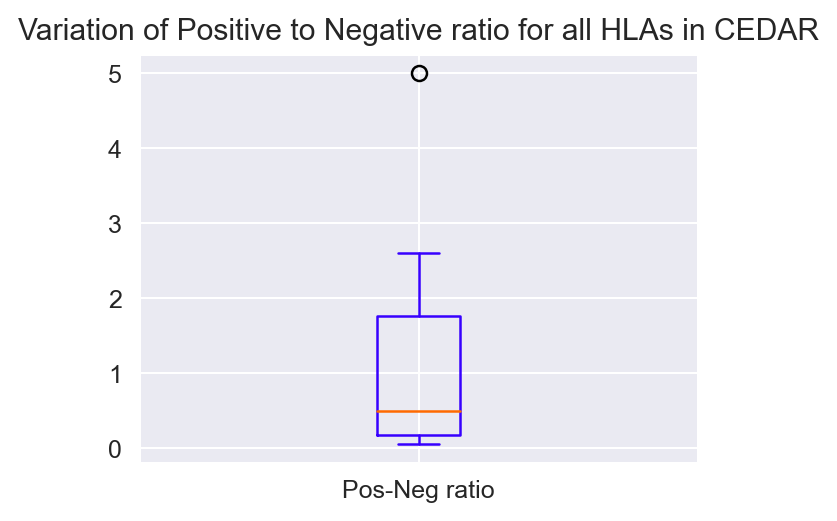

In [21]:
# POS-NEG ratio boxplot
pd.options.display.max_rows=999
gb_count = cedar.groupby(['HLA', 'agg_label'])[['Peptide']].count()
gb_total = cedar.groupby(['HLA'])[['Peptide']].count()
ratios = gb_count/gb_total
sorted_ratios = (ratios.query('agg_label==1').reset_index(level=1, drop = True) / ratios.query('agg_label==0').reset_index(level=1, drop = True))\
                .rename(columns={'Peptide':'Pos-Neg ratio'})\
                .replace(np.nan, np.inf).sort_values('Pos-Neg ratio', ascending=False)
f,a = plt.subplots(1,1, figsize=(4,3))
sorted_ratios.plot(kind='box', title = 'Variation of Positive to Negative ratio for all HLAs in CEDAR', ax = a)
pd.options.display.max_rows=10 

In [22]:
len(gb_count.query('agg_label==1')), len(gb_count.query('agg_label==0')), len(gb_count.reset_index(level=1).index.unique())

(63, 52, 63)

Text(0.5, 1.0, '% of Positive peptides vs number of positive peptides in dataset per HLA')

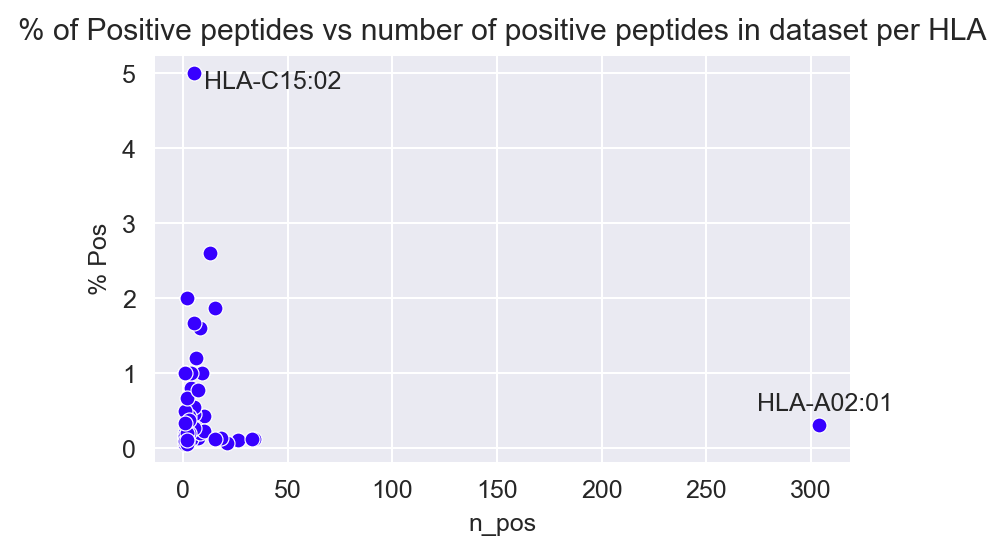

In [23]:
f,a = plt.subplots(1,1, figsize=(5,3))
npos_ratios = gb_count.query('agg_label==1').reset_index(level=1, drop=True).rename(columns={'Peptide':'n_pos'})\
                      .merge(sorted_ratios.rename(columns={'Pos-Neg ratio':'% Pos'}), left_index=True,right_index=True)
sns.scatterplot(data=npos_ratios, x = 'n_pos', y= '% Pos')

max_x = npos_ratios.iloc[npos_ratios['n_pos'].argmax()].name
max_y = npos_ratios.iloc[npos_ratios['% Pos'].replace(np.inf, 0).argmax()].name
# label outlier in x
a.text(npos_ratios.loc[max_x]['n_pos']-30, npos_ratios.loc[max_x]['% Pos']+0.2, max_x)
# label outlier in y
a.text(npos_ratios.loc[max_y]['n_pos']+5, npos_ratios.loc[max_y]['% Pos']-0.2, max_y)
a.set_title('% of Positive peptides vs number of positive peptides in dataset per HLA')

## TOP params

### Check overall best

In [30]:
overall_best_prime = df_simple.sort_values('score_concat_prime_auc', ascending=False).head(3)
overall_best_cedar = df_simple.sort_values('score_concat_cedar_auc', ascending=False).head(3)
overall_best_valid = df_simple.sort_values('score_avg_valid_auc', ascending=False).head(3)

In [31]:
display(overall_best_prime)
display(overall_best_cedar)
display(overall_best_valid)

,add_aaprop,add_rank,blsm,encoding,model,remove_pep,score_avg_valid_auc,score_concat_cedar_auc,score_concat_prime_auc,standardize,trainset,weight
660,True,True,BL62FREQ,blosum,RF,False,0.815808,0.686973,0.712916,True,cedar_hp_rank_uni,Mask
628,True,True,NaN,onehot,RF,False,0.821061,0.691135,0.712710,True,cedar_hp_rank_uni,Mask
636,True,True,BL62FREQ,blosum,RF,False,0.817853,0.689484,0.712673,True,cedar_hp_rank_uni,Shannon


,add_aaprop,add_rank,blsm,encoding,model,remove_pep,score_avg_valid_auc,score_concat_cedar_auc,score_concat_prime_auc,standardize,trainset,weight
420,False,True,NaN,onehot,RF,False,0.716188,0.722223,0.695267,True,cedar,None
421,False,True,NaN,onehot,RF,False,0.715281,0.715207,0.708767,False,cedar,None
401,True,True,NaN,onehot,RF,False,0.706503,0.713380,0.678910,False,cedar,Shannon


,add_aaprop,add_rank,blsm,encoding,model,remove_pep,score_avg_valid_auc,score_concat_cedar_auc,score_concat_prime_auc,standardize,trainset,weight
620,False,True,NaN,onehot,RF,False,0.831797,0.704149,0.706108,True,cedar_hp_rank_uni,None
621,False,True,NaN,onehot,RF,False,0.831713,0.704180,0.706140,False,cedar_hp_rank_uni,None
909,True,True,NaN,onehot,XGB,False,0.830574,0.690890,0.708687,False,cedar_hp_rank_uni,KL


In [278]:
print('\ncedar_auc')
display(df_simple.loc[cedar_auc['best_idx']].drop(columns=['lr','wd']).groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))
print('\nprime_auc')
display(df_simple.loc[prime_auc['best_idx']].drop(columns=['lr','wd']).groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))
print('\nvalid_auc')
display(df_simple.loc[valid_auc['best_idx']].drop(columns=['lr','wd']).groupby(['add_rank','add_aaprop','weight','encoding']).count()[['model']].sort_values('model', ascending=False).head(10))



cedar_auc


model
add_rank add_aaprop weight  encoding       
True     False      None    onehot       11
                            blosum        9
         True       Shannon onehot        9
False    True       Shannon blosum        8
True     True       KL      blosum        7
                    None    blosum        7
                            onehot        7
         False      KL      onehot        6
False    True       KL      blosum        6
True     False      Shannon onehot        6


prime_auc


model
add_rank add_aaprop weight  encoding       
True     False      KL      onehot       15
                    None    blosum       14
                    Shannon onehot       12
                            blosum        7
         True       None    blosum        7
                    KL      blosum        6
                            onehot        6
                    Mask    blosum        6
         False      KL      blosum        5
         True       Shannon blosum        5


valid_auc


model
add_rank add_aaprop weight  encoding       
True     False      None    blosum       15
                            onehot       10
         True       None    blosum        9
         False      KL      onehot        7
         True       None    onehot        7
         False      KL      blosum        6
                    Mask    onehot        6
                    Shannon blosum        6
                            onehot        6
                    Mask    blosum        5

## TOP method

In [73]:
def get_top_100(df, param_col, score_col='score_concat_cedar_auc', param_value=None):
    """
    Gets the top 100 best performance given a score_col 
    and either query a given param (ex : param_col='standardize', param_value=True) or returns a dict of the top for all possible param values
    """
    if param_value is None:
        values = df[param_col].unique()
        queries = [df.query(f'{param_col}==@val').sort_values(score_col, ascending=False) for val in values]
        return {val: q.head(min(100, len(q))) for q,val in zip(queries, values)}
    else:
        query = df.query(f'{param_col}==@param_value')
        return query.sort_values(score_col, ascending=False).head(min(100, len(query)))

In [38]:
top_100_std = get_top_100(df_simple, 'standardize', 'score_concat_cedar_auc', True)
top_100_std.groupby(['encoding', 'add_rank', 'model']).count()

add_aaprop  blsm  remove_pep  score_avg_valid_auc  \
encoding add_rank model                                                      
blosum   True     RF             36    36          36                   36   
                  XGB            11    11          11                   11   
onehot   False    RF              4     0           4                    4   
                  XGB             2     0           2                    2   
         True     RF             25     0          25                   25   
                  XGB            22     0          22                   22   

                         score_concat_cedar_auc  score_concat_prime_auc  \
encoding add_rank model                                                   
blosum   True     RF                         36                      36   
                  XGB                        11                      11   
onehot   False    RF                          4                       4   
                  XGB                         2                       2   
         True     RF                         25                      25   
                  XGB                        22                      22   

                         standardize  trainset  weight  
encoding add_rank model                                 
blosum   True     RF              36        36      36  
                  XGB             11        11      11  
onehot   False    RF               4         4       4  
                  XGB              2         2       2  
         True     RF              25        25      25  
                  XGB             22        22      22

### PR curve test

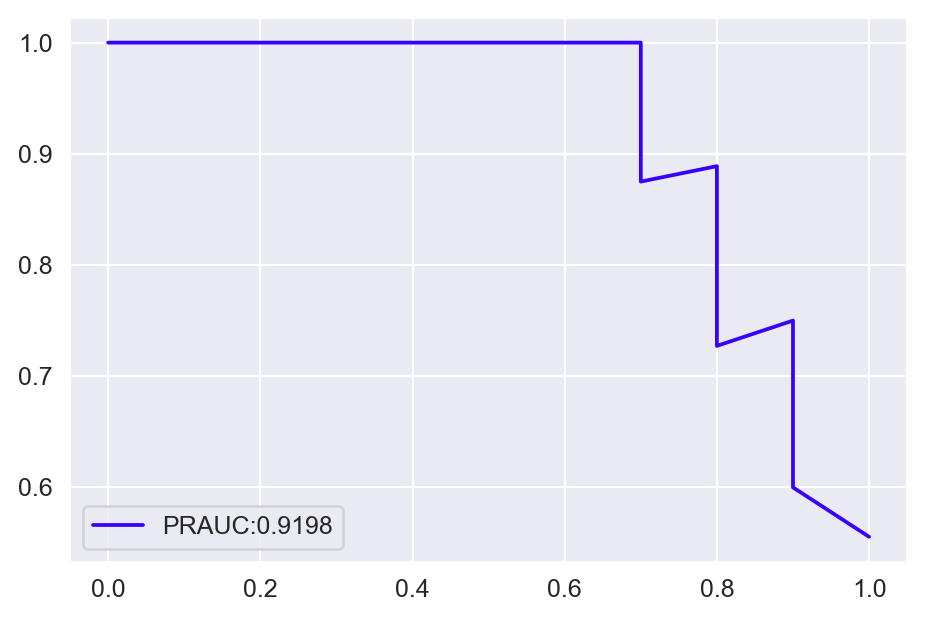

In [83]:
from sklearn.metrics import precision_recall_curve, auc
y_true = [1,1,1,0,1,
          0,1,0,0,1,
          0,0,1,0,1,
          0,1,0,0,1]
y_score = [0.8, 0.9, 0.75, 0.45, 0.4,
           0.3, 0.2, 0.6, 0.2, 0.99,
           0.3, 0.25, 0.65, 0.5, 0.75,
           0.0, 0.99, 0.2, 0.12, 0.57]

prec, rec, _ = precision_recall_curve(y_true, y_score)
prauc = auc(rec,prec)
plt.plot(rec, prec, label = f'PRAUC:{round(prauc,4)}')
plt.legend()

### Top encoding-weighting pair

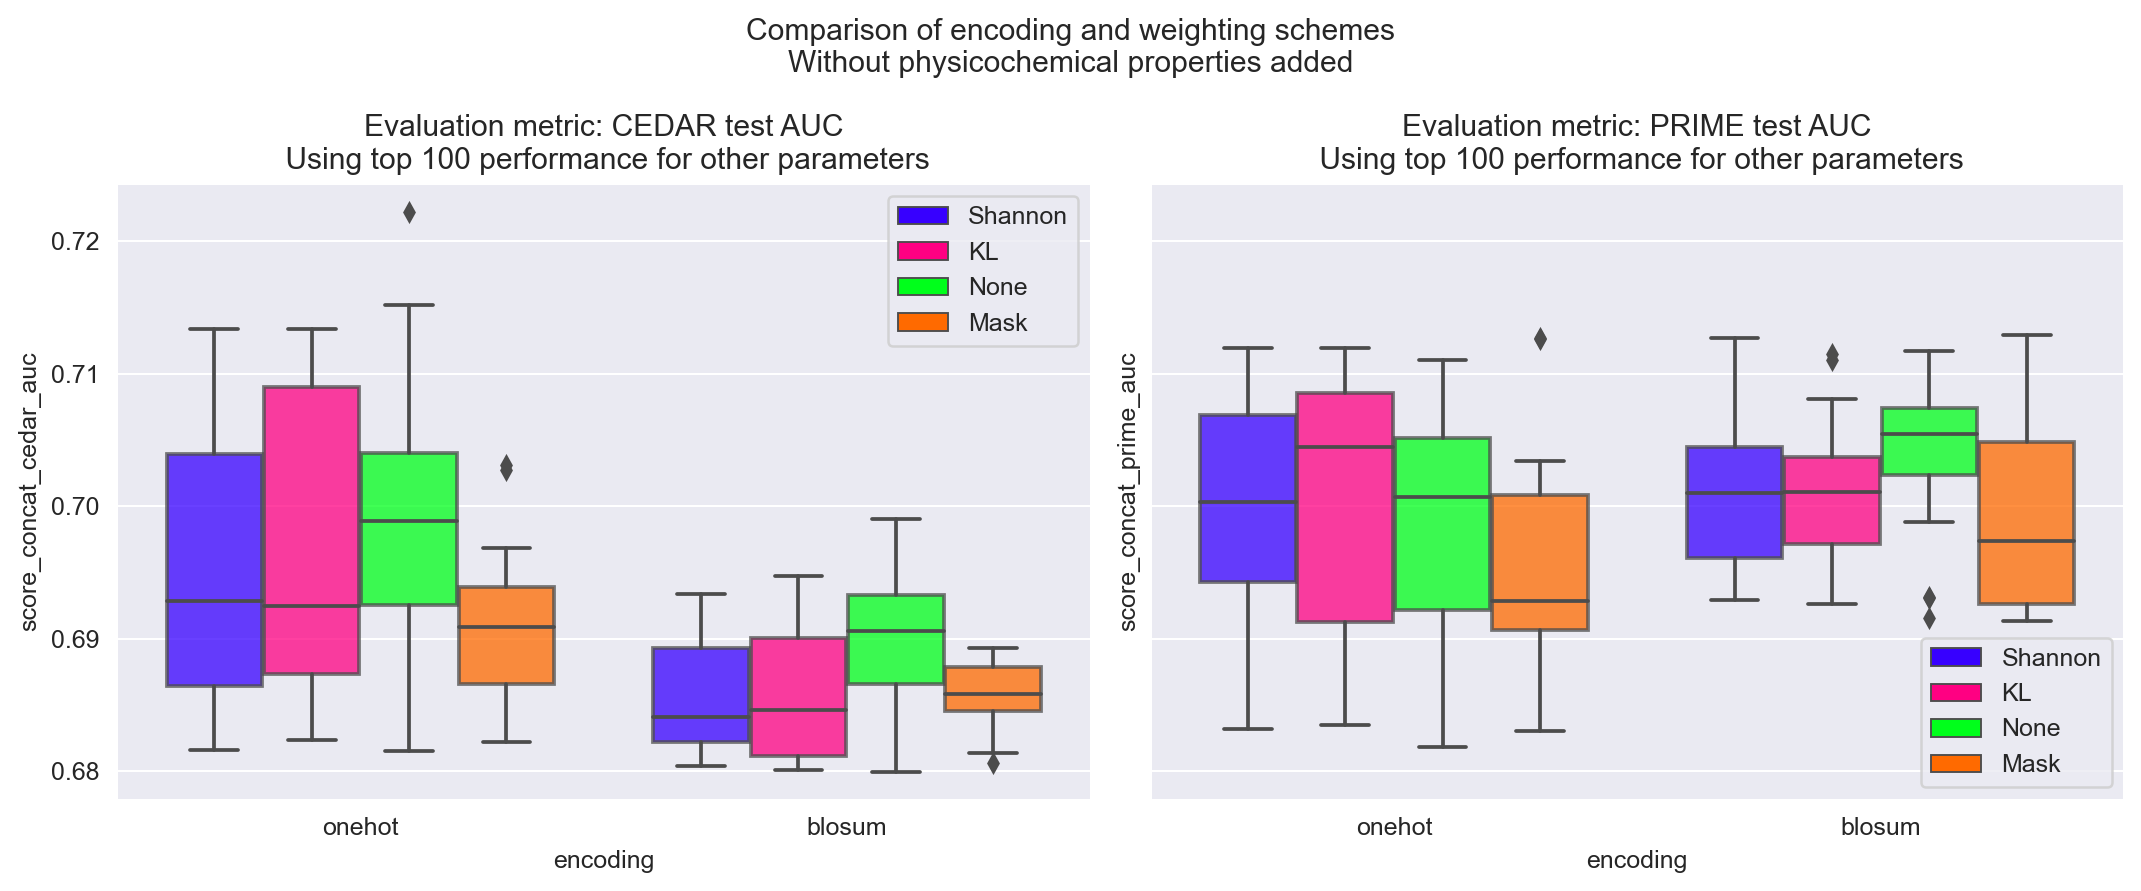

In [167]:
# Top Encoding and Weighting
tmp = sns.color_palette('hsv', n_colors=13)
palette = [tmp[-4], tmp[-1], tmp[4], tmp[0]]
sns.set_palette(palette)

f,a = plt.subplots(1,2, figsize=(12,5), sharey=True)

f.suptitle('Comparison of encoding and weighting schemes\nWithout physicochemical properties added')
top100_methods = get_top_100(df_simple,#.query('add_rank==False and remove_pep==False and add_aaprop ==False'),
                             'encoding', 'score_concat_cedar_auc')
concat = pd.concat([x for _, x in top100_methods.items()])

sns.boxplot(data=concat, x='encoding', hue='weight',  y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL','None','Mask'],
              saturation = 1, boxprops={'alpha':0.75}, ax=a[0], whis=1)
a[0].legend(loc = 'upper right')#bbox_to_anchor=(1.25,1))
a[0].set_title('Evaluation metric: CEDAR test AUC\n Using top 100 performance for other parameters')

# on PRIME
top100_methods = get_top_100(df_simple,#.query('add_rank==False and remove_pep==False and add_aaprop ==False'),
                             'encoding', 'score_concat_prime_auc')
concat = pd.concat([x for _, x in top100_methods.items()])

sns.boxplot(data=concat, x='encoding', hue='weight',  y='score_concat_prime_auc', hue_order = ['Shannon', 'KL','None','Mask'],
              saturation = 1, boxprops={'alpha':0.75}, ax=a[1], whis=1)
a[1].legend(loc = 'lower right')#bbox_to_anchor=(1.25,1))
a[1].set_title('Evaluation metric: PRIME test AUC\n Using top 100 performance for other parameters')
f.tight_layout()

Seems like KL and None x Onehot is the best combination of weighting and encoding. 

--> None better on CEDAR data, but KL better on PRIME data

### Get rank and chemprops

In [68]:
tmp_cedar.columns

Index(['add_aaprop', 'add_rank', 'blsm', 'encoding', 'model', 'remove_pep',
       'score_avg_valid_auc', 'score_concat_cedar_auc',
       'score_concat_prime_auc', 'standardize', 'trainset', 'weight'],
      dtype='object')

(-5.0, 20.0)

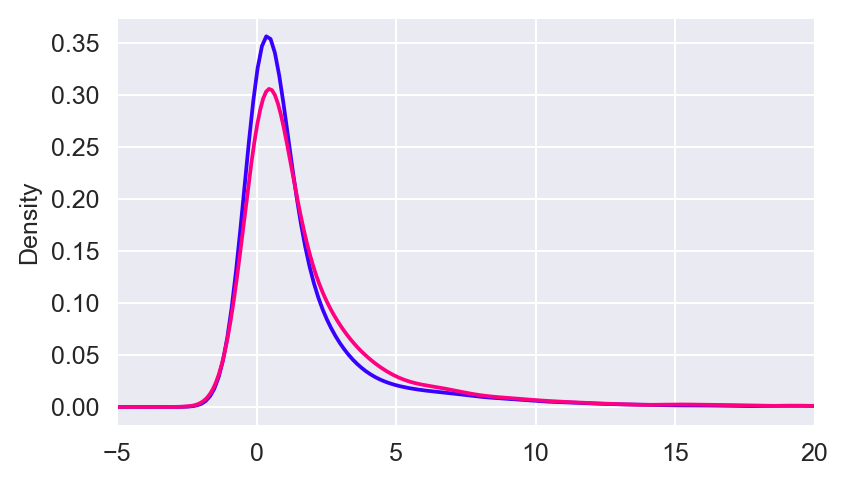

In [172]:
f,a = plt.subplots(1,1, figsize=(5,3))
prime.query('StudyOrigin != "Random"')['NetMHCpanEL'].plot(kind='kde', ax = a)
cedar['trueHLA_EL_rank'].plot(kind='kde', ax= a)
a.set_xlim([-5, 20])


In [178]:
cedar_viral.query('dataset=="viral"').groupby('HLA').count()

,Peptide,trueHLA_EL_rank,agg_label,fold,BA_rank,BA_score,Core,Gl,Gp,Icore,Il,Ip,Of,PMIDs,allele,core,dataset,icore,id,label,len,non_aa_pep,non_aa_prot,number_papers_negative,number_papers_positive,peptide_start,peptide_stop,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,prot_sequence,responses,subj_responded,subj_tested,target_bin_2,target_qual_corrected,total_count,training,uniprot_id
HLA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HLA-A01:01,25,25,25,25,0,0,25,25,25,25,25,25,25,0,25,0,25,0,25,0,25,25,25,25,25,25,25,0,0,0,0,25,0,25,25,25,25,0,25,25
HLA-A02:01,25,25,25,25,0,0,25,25,25,25,25,25,25,0,25,0,25,0,25,0,25,25,25,25,25,25,25,0,0,0,0,25,0,25,25,25,25,0,25,25
HLA-A02:02,19,19,19,19,0,0,19,19,19,19,19,19,19,0,19,0,19,0,19,0,19,19,19,19,19,19,19,0,0,0,0,19,0,19,19,19,19,0,19,19
HLA-A02:03,10,10,10,10,0,0,10,10,10,10,10,10,10,0,10,0,10,0,10,0,10,10,10,10,10,10,10,0,0,0,0,10,0,10,10,10,10,0,10,10
HLA-A02:05,10,10,10,10,0,0,10,10,10,10,10,10,10,0,10,0,10,0,10,0,10,10,10,10,10,10,10,0,0,0,0,10,0,10,10,10,10,0,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HLA-C05:01,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,1,1,0,0,0,0,1,0,1,1,1,1,0,1,1
HLA-C06:02,10,10,10,10,0,0,10,10,10,10,10,10,10,0,10,0,10,0,10,0,10,10,10,10,10,10,10,0,0,0,0,10,0,10,10,10,10,0,10,10
HLA-C07:01,15,15,15,15,0,0,15,15,15,15,15,15,15,0,15,0,15,0,15,0,15,15,15,15,15,15,15,0,0,0,0,15,0,15,15,15,15,0,15,15


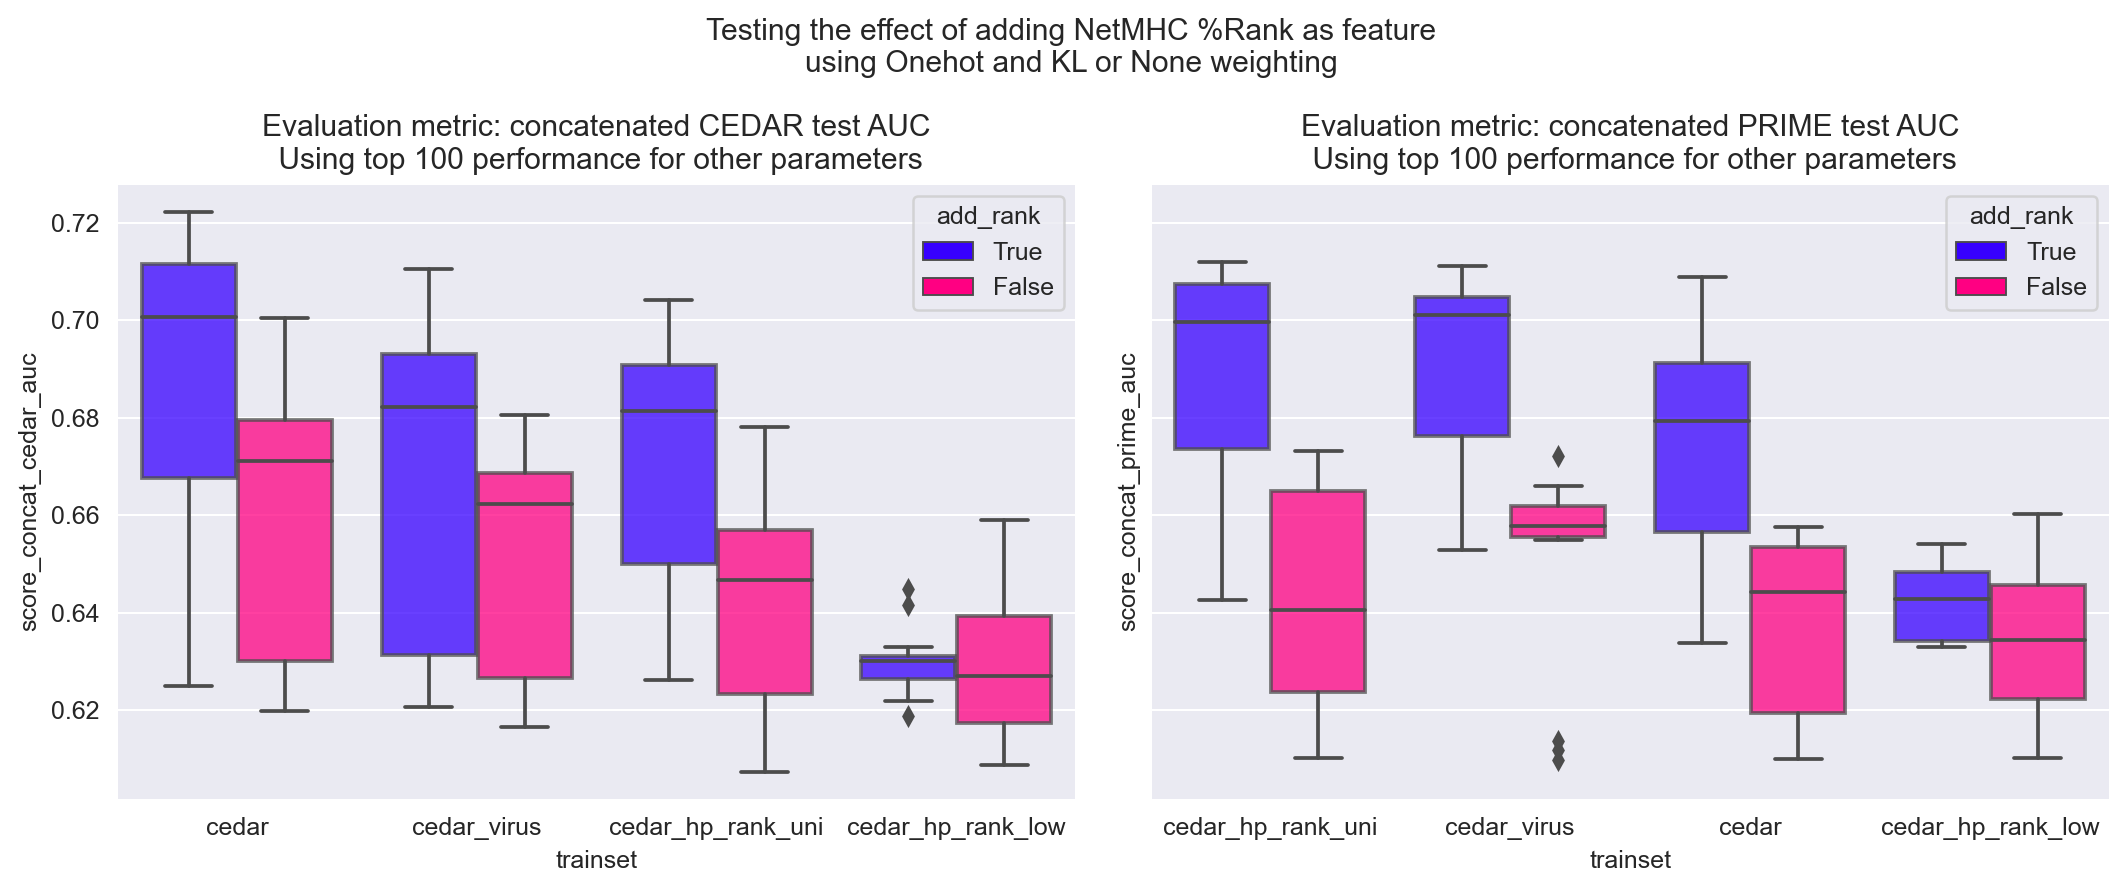

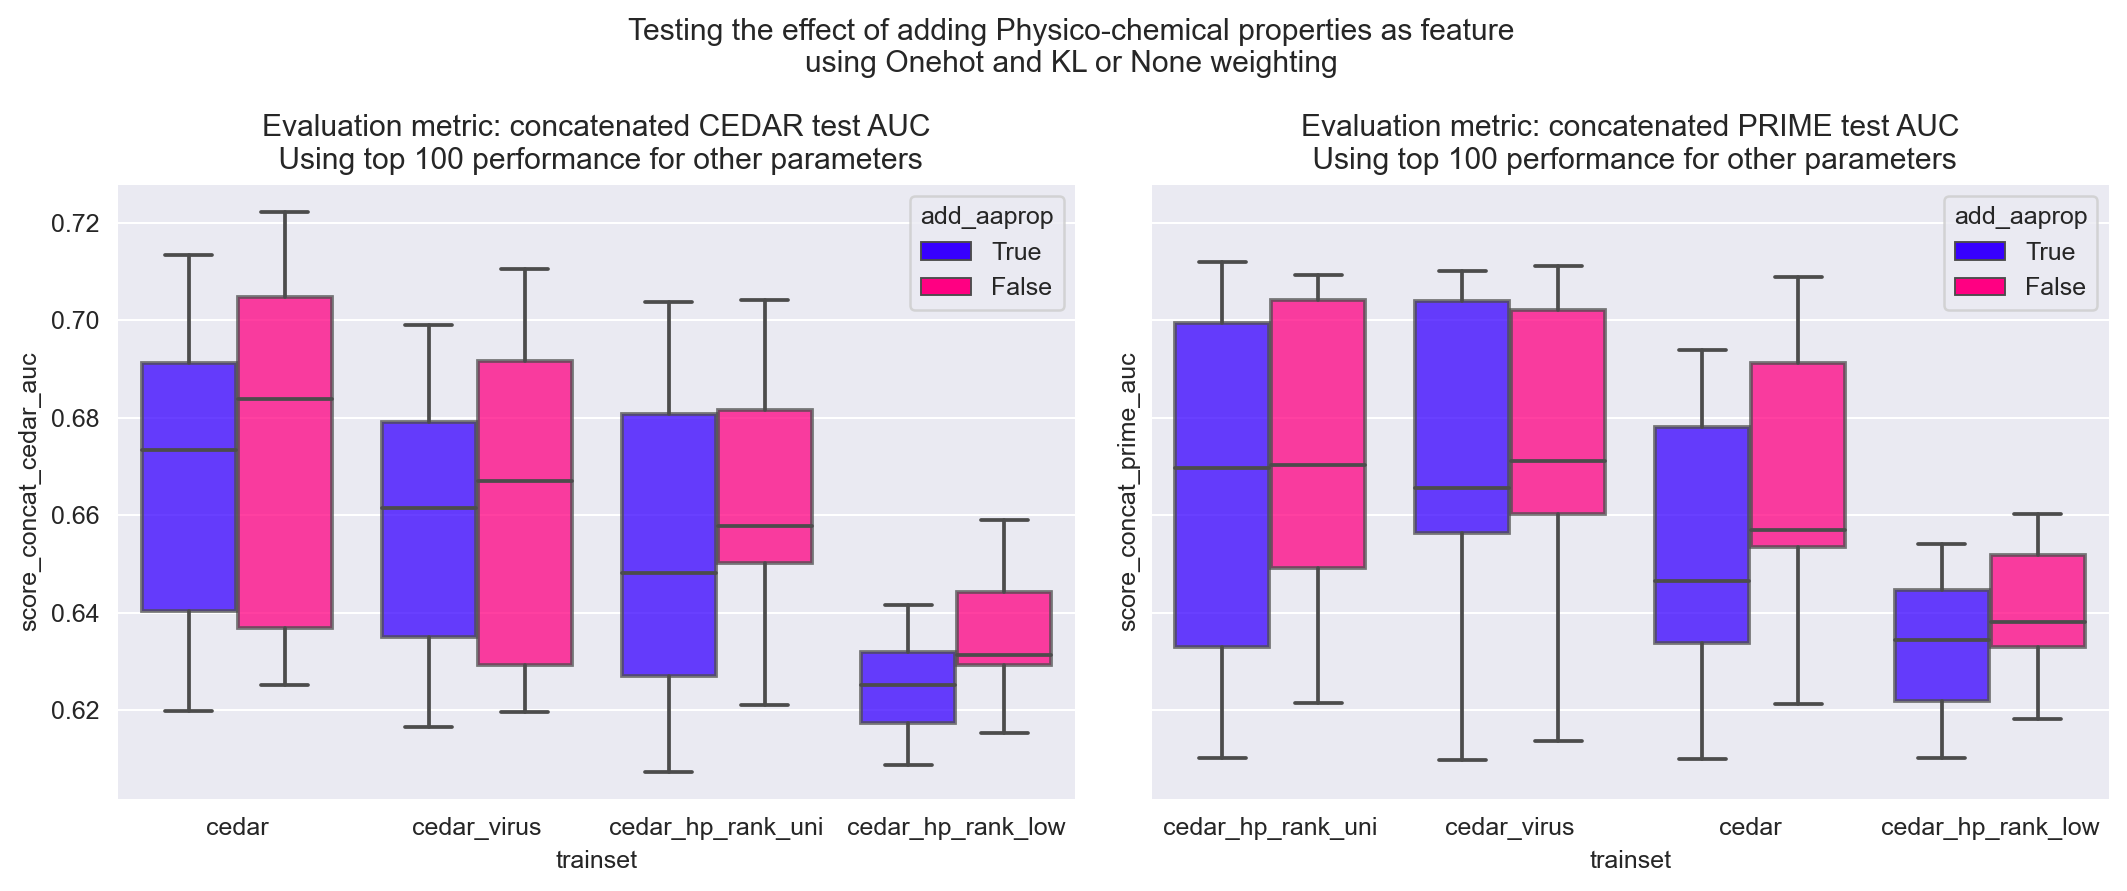

In [114]:
tmp = df_simple.query('encoding=="onehot" and (weight=="KL" or weight=="None")')
tmp_cedar = pd.concat([v for _,v in get_top_100(tmp, param_col = 'add_rank', score_col = 'score_concat_cedar_auc').items()])

tmp_prime = pd.concat([v for _,v in get_top_100(tmp, param_col = 'add_rank', score_col = 'score_concat_prime_auc').items()])


f,ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
a = ax.ravel()
f.suptitle('Testing the effect of adding NetMHC %Rank as feature\n'\
           'using Onehot and KL or None weighting')

sns.boxplot(data=tmp_cedar, x='trainset', hue='add_rank',  y='score_concat_cedar_auc',
              saturation = 1, boxprops={'alpha':0.75}, ax=a[0], whis=1.5, hue_order = [True, False])
a[0].set_title('Evaluation metric: concatenated CEDAR test AUC\n Using top 100 performance for other parameters')


sns.boxplot(data=tmp_prime, x='trainset', hue='add_rank',  y='score_concat_prime_auc',
              saturation = 1, boxprops={'alpha':0.75}, ax=a[1], whis=1.5, hue_order = [True, False])
a[1].set_title('Evaluation metric: concatenated PRIME test AUC\n Using top 100 performance for other parameters')
f.tight_layout()

plt.setp(a[0].collections, alpha=.55)

plt.setp(a[1].collections, alpha=.55)

#################################################
#                 CEDAR CHEMPROP                #
#################################################

f,ax = plt.subplots(1,2, figsize=(12,5), sharey=True)
a = ax.ravel()

f.suptitle('Testing the effect of adding Physico-chemical properties as feature\n'\
           'using Onehot and KL or None weighting')
sns.boxplot(data=tmp_cedar, x='trainset', hue='add_aaprop',  y='score_concat_cedar_auc',
              saturation = 1, boxprops={'alpha':0.75}, ax=a[0], whis=1.5,  hue_order = [True, False])
a[0].set_title('Evaluation metric: concatenated CEDAR test AUC\n Using top 100 performance for other parameters')


# PRIME CHEMPROP
sns.boxplot(data=tmp_prime, x='trainset', hue='add_aaprop',  y='score_concat_prime_auc',
              saturation = 1, boxprops={'alpha':0.75}, ax=a[1], whis=1.5,  hue_order = [True, False])
a[1].set_title('Evaluation metric: concatenated PRIME test AUC\n Using top 100 performance for other parameters')
f.tight_layout()

plt.setp(a[0].collections, alpha=.55)

plt.setp(a[1].collections, alpha=.55)


--> Just select add rank, cedar as train set

### overall top methods

In [89]:
tmp = df_simple.query('encoding=="onehot" and (weight=="KL" or weight=="None") and add_rank==True and trainset=="cedar"')

<AxesSubplot:>

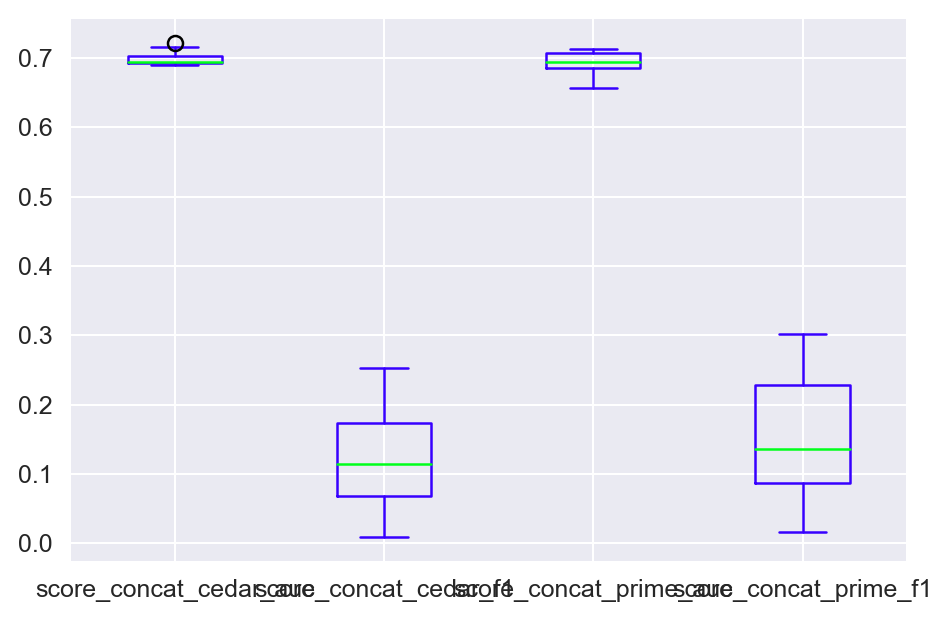

In [116]:
pd.options.display.max_rows = 15
overall_top100 = df.sort_values('score_concat_cedar_auc', ascending=False).head(100)
overall_top100.describe()[['score_concat_cedar_auc', 'score_concat_cedar_f1', 'score_concat_prime_auc', 'score_concat_prime_f1']]
overall_top100[['score_concat_cedar_auc', 'score_concat_cedar_f1', 'score_concat_prime_auc', 'score_concat_prime_f1']].plot(kind='box')

In [166]:
overall_top100

,trainset,model,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm,lr,wd
20,cedar,RF,None,12,onehot,False,True,False,False,True,0.695253,0.554288,0.137652,0.695267,0.554232,0.137700,0.724143,0.579791,0.153394,0.722223,0.577292,0.152815,0.716188,0.576978,0.165937,NaN,NaN,NaN
21,cedar,RF,None,12,onehot,False,True,False,False,False,0.708789,0.560402,0.074018,0.708767,0.560380,0.074110,0.717687,0.576628,0.066879,0.715207,0.573959,0.066958,0.715281,0.574729,0.069688,NaN,NaN,NaN
1,cedar,RF,Shannon,12,onehot,False,True,True,False,False,0.678965,0.547421,0.170173,0.678910,0.547400,0.170346,0.715840,0.576294,0.135888,0.713380,0.572276,0.137652,0.706503,0.573171,0.148132,NaN,NaN,NaN
9,cedar,RF,KL,12,onehot,False,True,True,False,False,0.679405,0.547299,0.167456,0.679347,0.547264,0.167625,0.715232,0.576815,0.139133,0.713340,0.572287,0.140351,0.707618,0.572539,0.144822,NaN,NaN,NaN
0,cedar,RF,Shannon,12,onehot,False,True,True,False,True,0.678967,0.547432,0.169708,0.678899,0.547416,0.169888,0.715302,0.576814,0.133490,0.712947,0.572691,0.135135,0.706327,0.572746,0.146535,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,cedar_virus,RF,None,12,blosum,False,True,False,False,False,0.708186,0.553752,0.172627,0.708141,0.553729,0.172743,0.693452,0.572159,0.145411,0.690032,0.567467,0.144966,0.693942,0.562435,0.139182,BL62LO,NaN,NaN
76,cedar,RF,KL,12,blosum,False,True,True,False,True,0.678013,0.543591,0.075571,0.677863,0.543386,0.075786,0.692832,0.570663,0.053139,0.689978,0.564906,0.052632,0.686777,0.566468,0.062586,BL62LO,NaN,NaN
254,cedar_hp_rank_uni,RF,None,12,blosum,False,True,False,False,True,0.708127,0.547256,0.068243,0.708010,0.547259,0.068279,0.689569,0.579819,0.061724,0.689872,0.578899,0.061047,0.820313,0.643548,0.069605,BL62FREQ,NaN,NaN
252,cedar_hp_rank_uni,RF,None,12,blosum,False,True,True,False,True,0.707937,0.543353,0.041459,0.707876,0.543361,0.041480,0.689543,0.575804,0.018530,0.689546,0.574498,0.018100,0.815151,0.638138,0.024826,BL62FREQ,NaN,NaN


In [165]:
pd.options.display.max_rows = 20
df.sort_values('score_concat_cedar_auc', ascending=False).head(100)\
  .groupby(['weight']).agg(count=('trainset','count'),
                           max_cedar_auc=('score_concat_cedar_auc','max'),
                           max_prime_auc=('score_concat_prime_auc','max'),
                           mean_cedar_auc=('score_concat_cedar_auc','mean'),
                           mean_prime_auc=('score_concat_prime_auc','mean'),
                          ).sort_values('max_cedar_auc', ascending=False)

,count,max_cedar_auc,max_prime_auc,mean_cedar_auc,mean_prime_auc
weight,,,,,
None,42,0.722223,0.711750,0.697552,0.696662
Shannon,23,0.713380,0.712601,0.698571,0.693850
KL,25,0.713340,0.711948,0.698167,0.694564
Mask,10,0.703109,0.712710,0.695287,0.694197


In [142]:
df.reset_index().sort_values('score_concat_cedar_auc',ascending=False).groupby('model').first()

,index,trainset,weight,max_len,encoding,mask,add_rank,add_aaprop,remove_pep,standardize,score_avg_prime_auc,score_avg_prime_auc_01,score_avg_prime_f1,score_concat_prime_auc,score_concat_prime_auc_01,score_concat_prime_f1,score_avg_cedar_auc,score_avg_cedar_auc_01,score_avg_cedar_f1,score_concat_cedar_auc,score_concat_cedar_auc_01,score_concat_cedar_f1,score_avg_valid_auc,score_avg_valid_auc_01,score_avg_valid_f1,blsm,lr,wd
model,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FFN,177,cedar,KL,12,blosum,False,True,True,False,True,0.637226,0.524862,0.065524,0.631765,0.524791,0.067904,0.637762,0.548287,0.050419,0.633731,0.542589,0.054363,0.646738,0.552891,0.036385,BL62FREQ,0.0005,0.01
LogReg,4,cedar,Shannon,12,onehot,False,False,True,False,True,0.610167,0.518748,0.016534,0.610159,0.518721,0.016569,0.659203,0.545422,0.031505,0.657323,0.542415,0.032448,0.656933,0.543896,0.032555,BL62FREQ,NaN,NaN
RF,20,cedar,None,12,onehot,False,True,False,False,True,0.695253,0.554288,0.137652,0.695267,0.554232,0.137700,0.724143,0.579791,0.153394,0.722223,0.577292,0.152815,0.716188,0.576978,0.165937,BL62LO,NaN,NaN
XGB,10,cedar,KL,12,onehot,False,True,False,False,True,0.687615,0.553822,0.233930,0.687600,0.553820,0.233996,0.711222,0.572980,0.195335,0.710797,0.570423,0.193309,0.694671,0.568169,0.228218,BL62LO,NaN,NaN


## ROC curves

Text(0.5, 1.0, 'ROC curves for best condition for each model type\nBaseline comparison with PRIME, NNAlign, and NetMHCpan %Rank\nEvaluated on CEDAR test set')

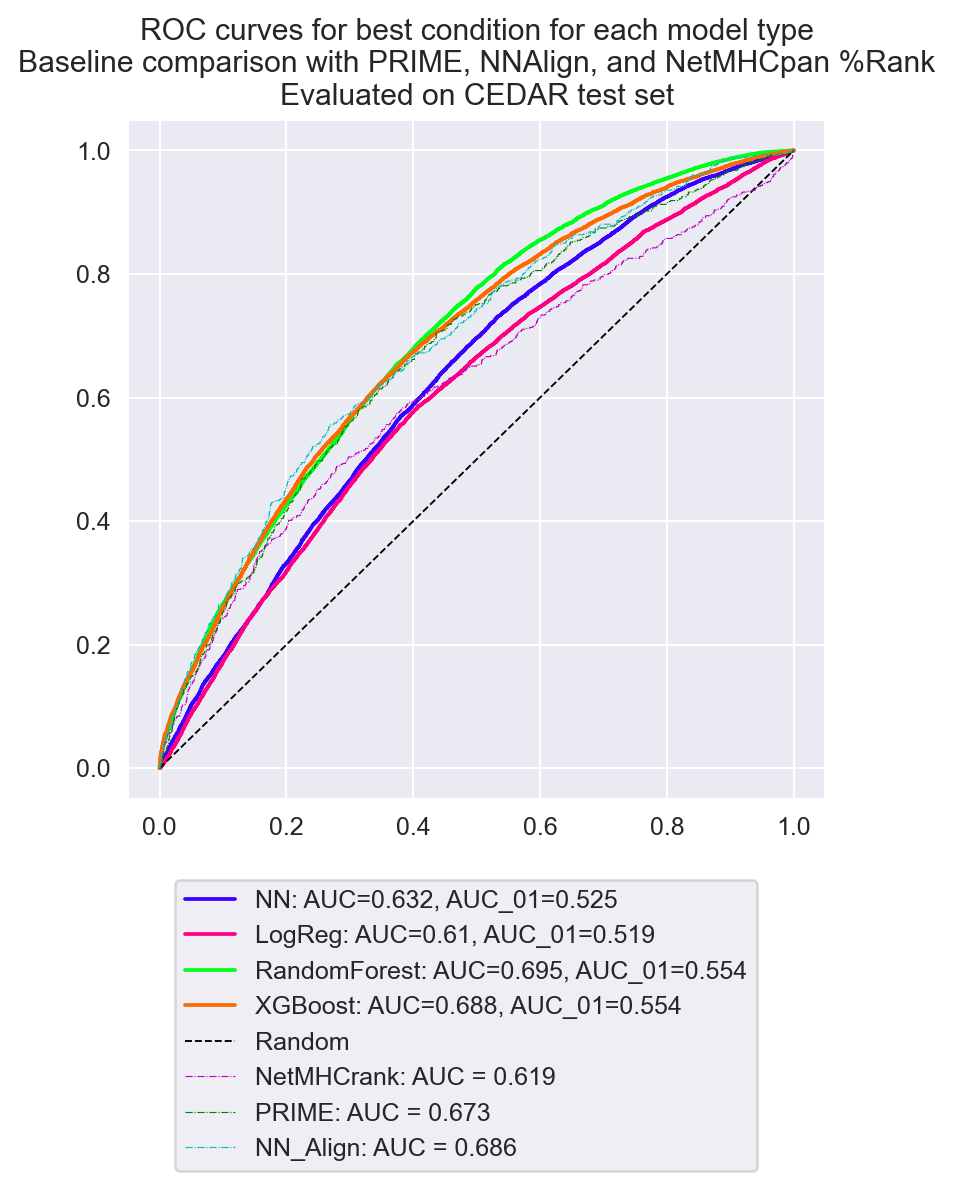

In [168]:
f,a = plt.subplots(1,1, figsize=(5,5))
top_model_results = {
    'NN': prime_nn[177],
    'LogReg': prime_log[4],
    'RandomForest': prime_rf[20],
    'XGBoost': prime_xgb_normal[10]}

for k,v in top_model_results.items():
    fpr, tpr = v['concatenated']['roc_curve']
    roc_auc = v['concatenated']['auc']
    roc_auc_01 = v['concatenated']['auc_01']
    sns.lineplot(x=fpr, y=tpr, label=f'{k}: AUC={round(roc_auc,3)}, AUC_01={round(roc_auc_01,3)}', estimator=None, ax=a)
    
sns.lineplot([0,1],[0,1], linestyle='--', linewidth=0.75, label='Random', color='k')
plot_baseline(a, 'cedar')
a.legend(bbox_to_anchor=(.92,-0.1))
a.set_title('ROC curves for best condition for each model type\nBaseline comparison with PRIME, NNAlign, and NetMHCpan %Rank\nEvaluated on CEDAR test set')

## AUC boxplots

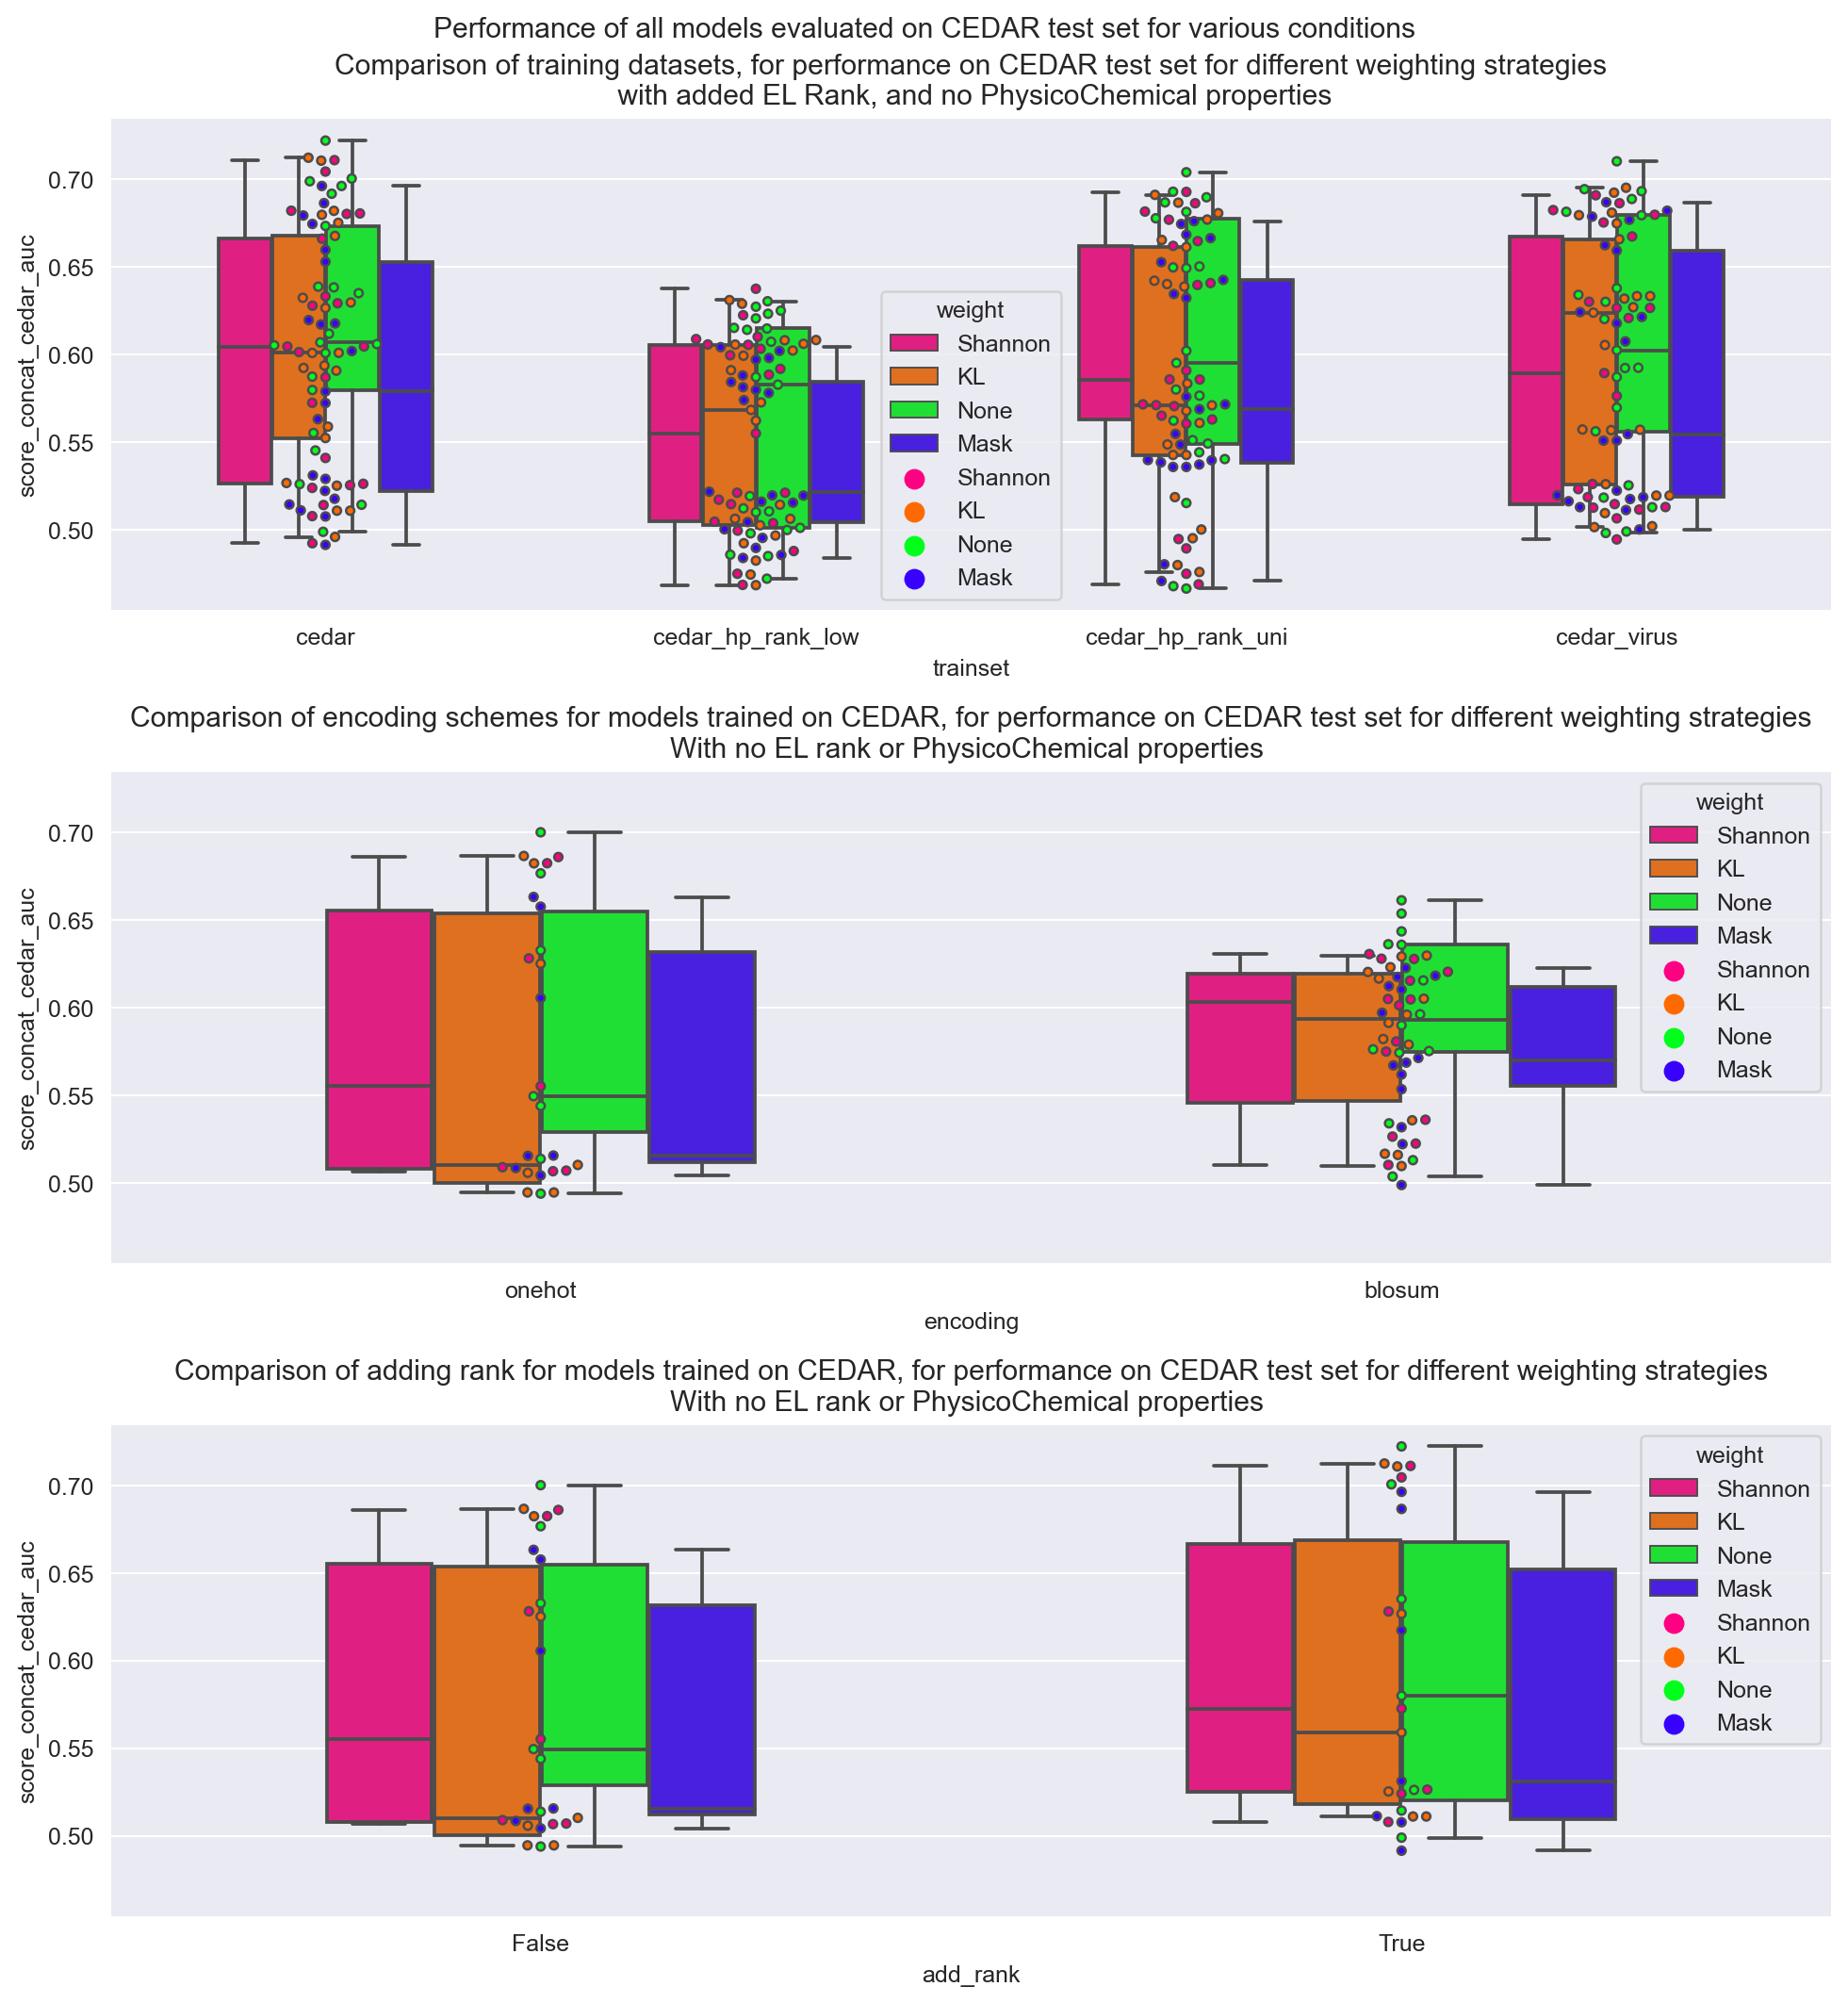

In [396]:
f,a = plt.subplots(3,1, figsize=(11,12), sharey=True)

f.suptitle('Performance of all models evaluated on CEDAR test set for various conditions')
sns.set_palette(palette)
# 1

sns.boxplot(data=df_simple.query('add_rank==True and remove_pep==False and add_aaprop == False and standardize==True')
                ,x= 'trainset' , hue= 'weight', y = 'score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[0], width=0.5)
sns.swarmplot(data=df_simple.query('add_rank==True and remove_pep==False and add_aaprop == False and standardize==True')
                ,x= 'trainset' , hue= 'weight', y = 'score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[0], linewidth=1, size = 3.5)
a[0].set_title('Comparison of training datasets, for performance on CEDAR test set for different weighting strategies\n with added EL Rank, and no PhysicoChemical properties')
# 2


sns.boxplot(data=df_simple.query('trainset=="cedar" and add_rank==False and add_aaprop==False and remove_pep==False and standardize==True')
                ,x='encoding', y = 'score_concat_cedar_auc', hue = 'weight', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[1], width=0.5)
sns.swarmplot(data=df_simple.query('trainset=="cedar" and add_rank==False and add_aaprop==False and remove_pep==False and standardize==True')
                ,x='encoding', y = 'score_concat_cedar_auc', hue = 'weight', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[1], linewidth=1, size = 3.5)
a[1].set_title('Comparison of encoding schemes for models trained on CEDAR, for performance on CEDAR test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
# 

sns.boxplot(data=df_simple.query('trainset=="cedar" and encoding=="onehot" and add_aaprop ==False and remove_pep==False and standardize==True')
                ,x='add_rank', hue = 'weight', y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[2], width=0.5)
sns.swarmplot(data=df_simple.query('trainset=="cedar" and encoding=="onehot" and add_aaprop ==False and remove_pep==False and standardize==True')
                ,x='add_rank', hue = 'weight', y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[2], linewidth=1, size = 3.5)
a[2].set_title('Comparison of adding rank for models trained on CEDAR, for performance on CEDAR test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
f.tight_layout()

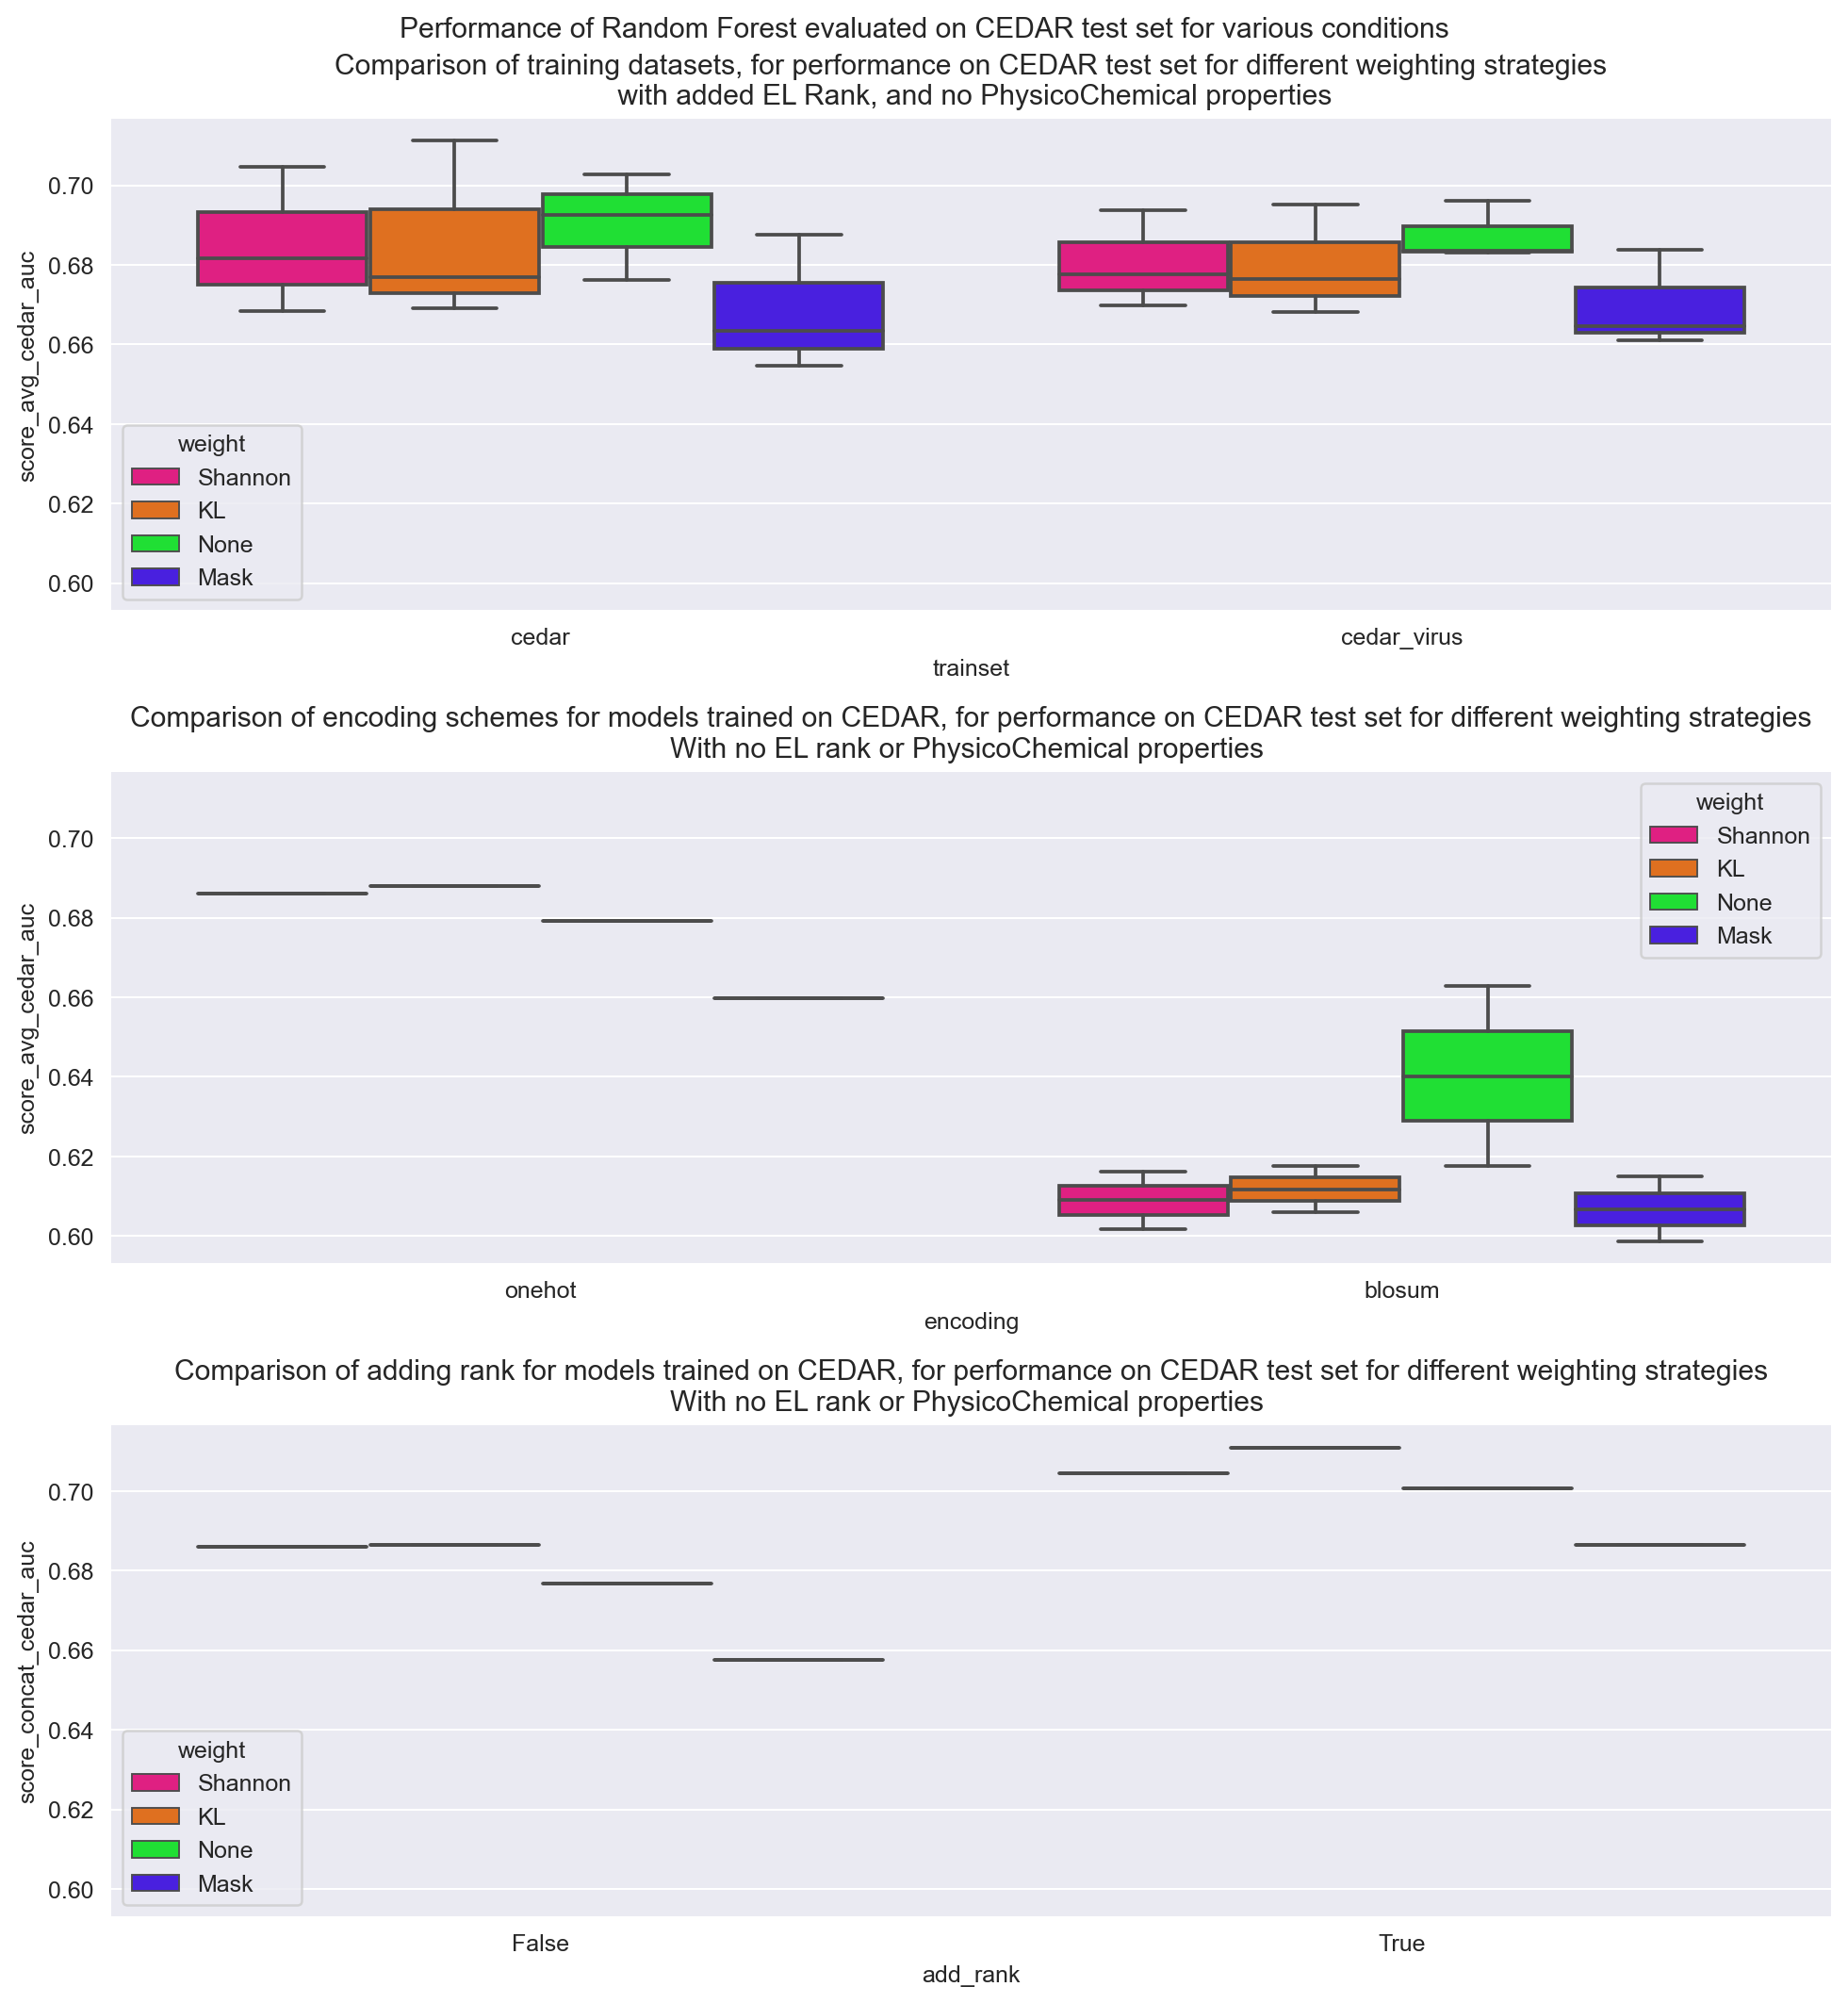

In [328]:
f,a = plt.subplots(3,1, figsize=(11,12), sharey=True)
PAL = sns.color_palette('hsv', n_colors=13)
palette = [PAL[-1], PAL[0], PAL[4], PAL [-4]]
f.suptitle('Performance of Random Forest evaluated on CEDAR test set for various conditions')
sns.set_palette(palette)
rf_subset=df_rf
# 1
sns.boxplot(data=df_xgb_normal.query('add_rank==True and remove_pep==False and add_aaprop == False and standardize==True'),
            orient='v',x= 'trainset' , hue= 'weight', y = 'score_avg_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[0])
a[0].set_title('Comparison of training datasets, for performance on CEDAR test set for different weighting strategies\n with added EL Rank, and no PhysicoChemical properties')
# 2

sns.boxplot(data=df_xgb_normal.query('trainset=="cedar" and add_rank==False and add_aaprop==False and remove_pep==False and standardize==True'),
            orient='v', x='encoding', y = 'score_avg_cedar_auc', hue = 'weight', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[1])
a[1].set_title('Comparison of encoding schemes for models trained on CEDAR, for performance on CEDAR test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
# 
sns.boxplot(data=df_xgb_normal.query('trainset=="cedar" and encoding=="onehot" and add_aaprop ==False and remove_pep==False and standardize==True'),
            orient='v',
            x='add_rank', hue = 'weight', y='score_concat_cedar_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[2])
a[2].set_title('Comparison of adding rank for models trained on CEDAR, for performance on CEDAR test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
f.tight_layout()

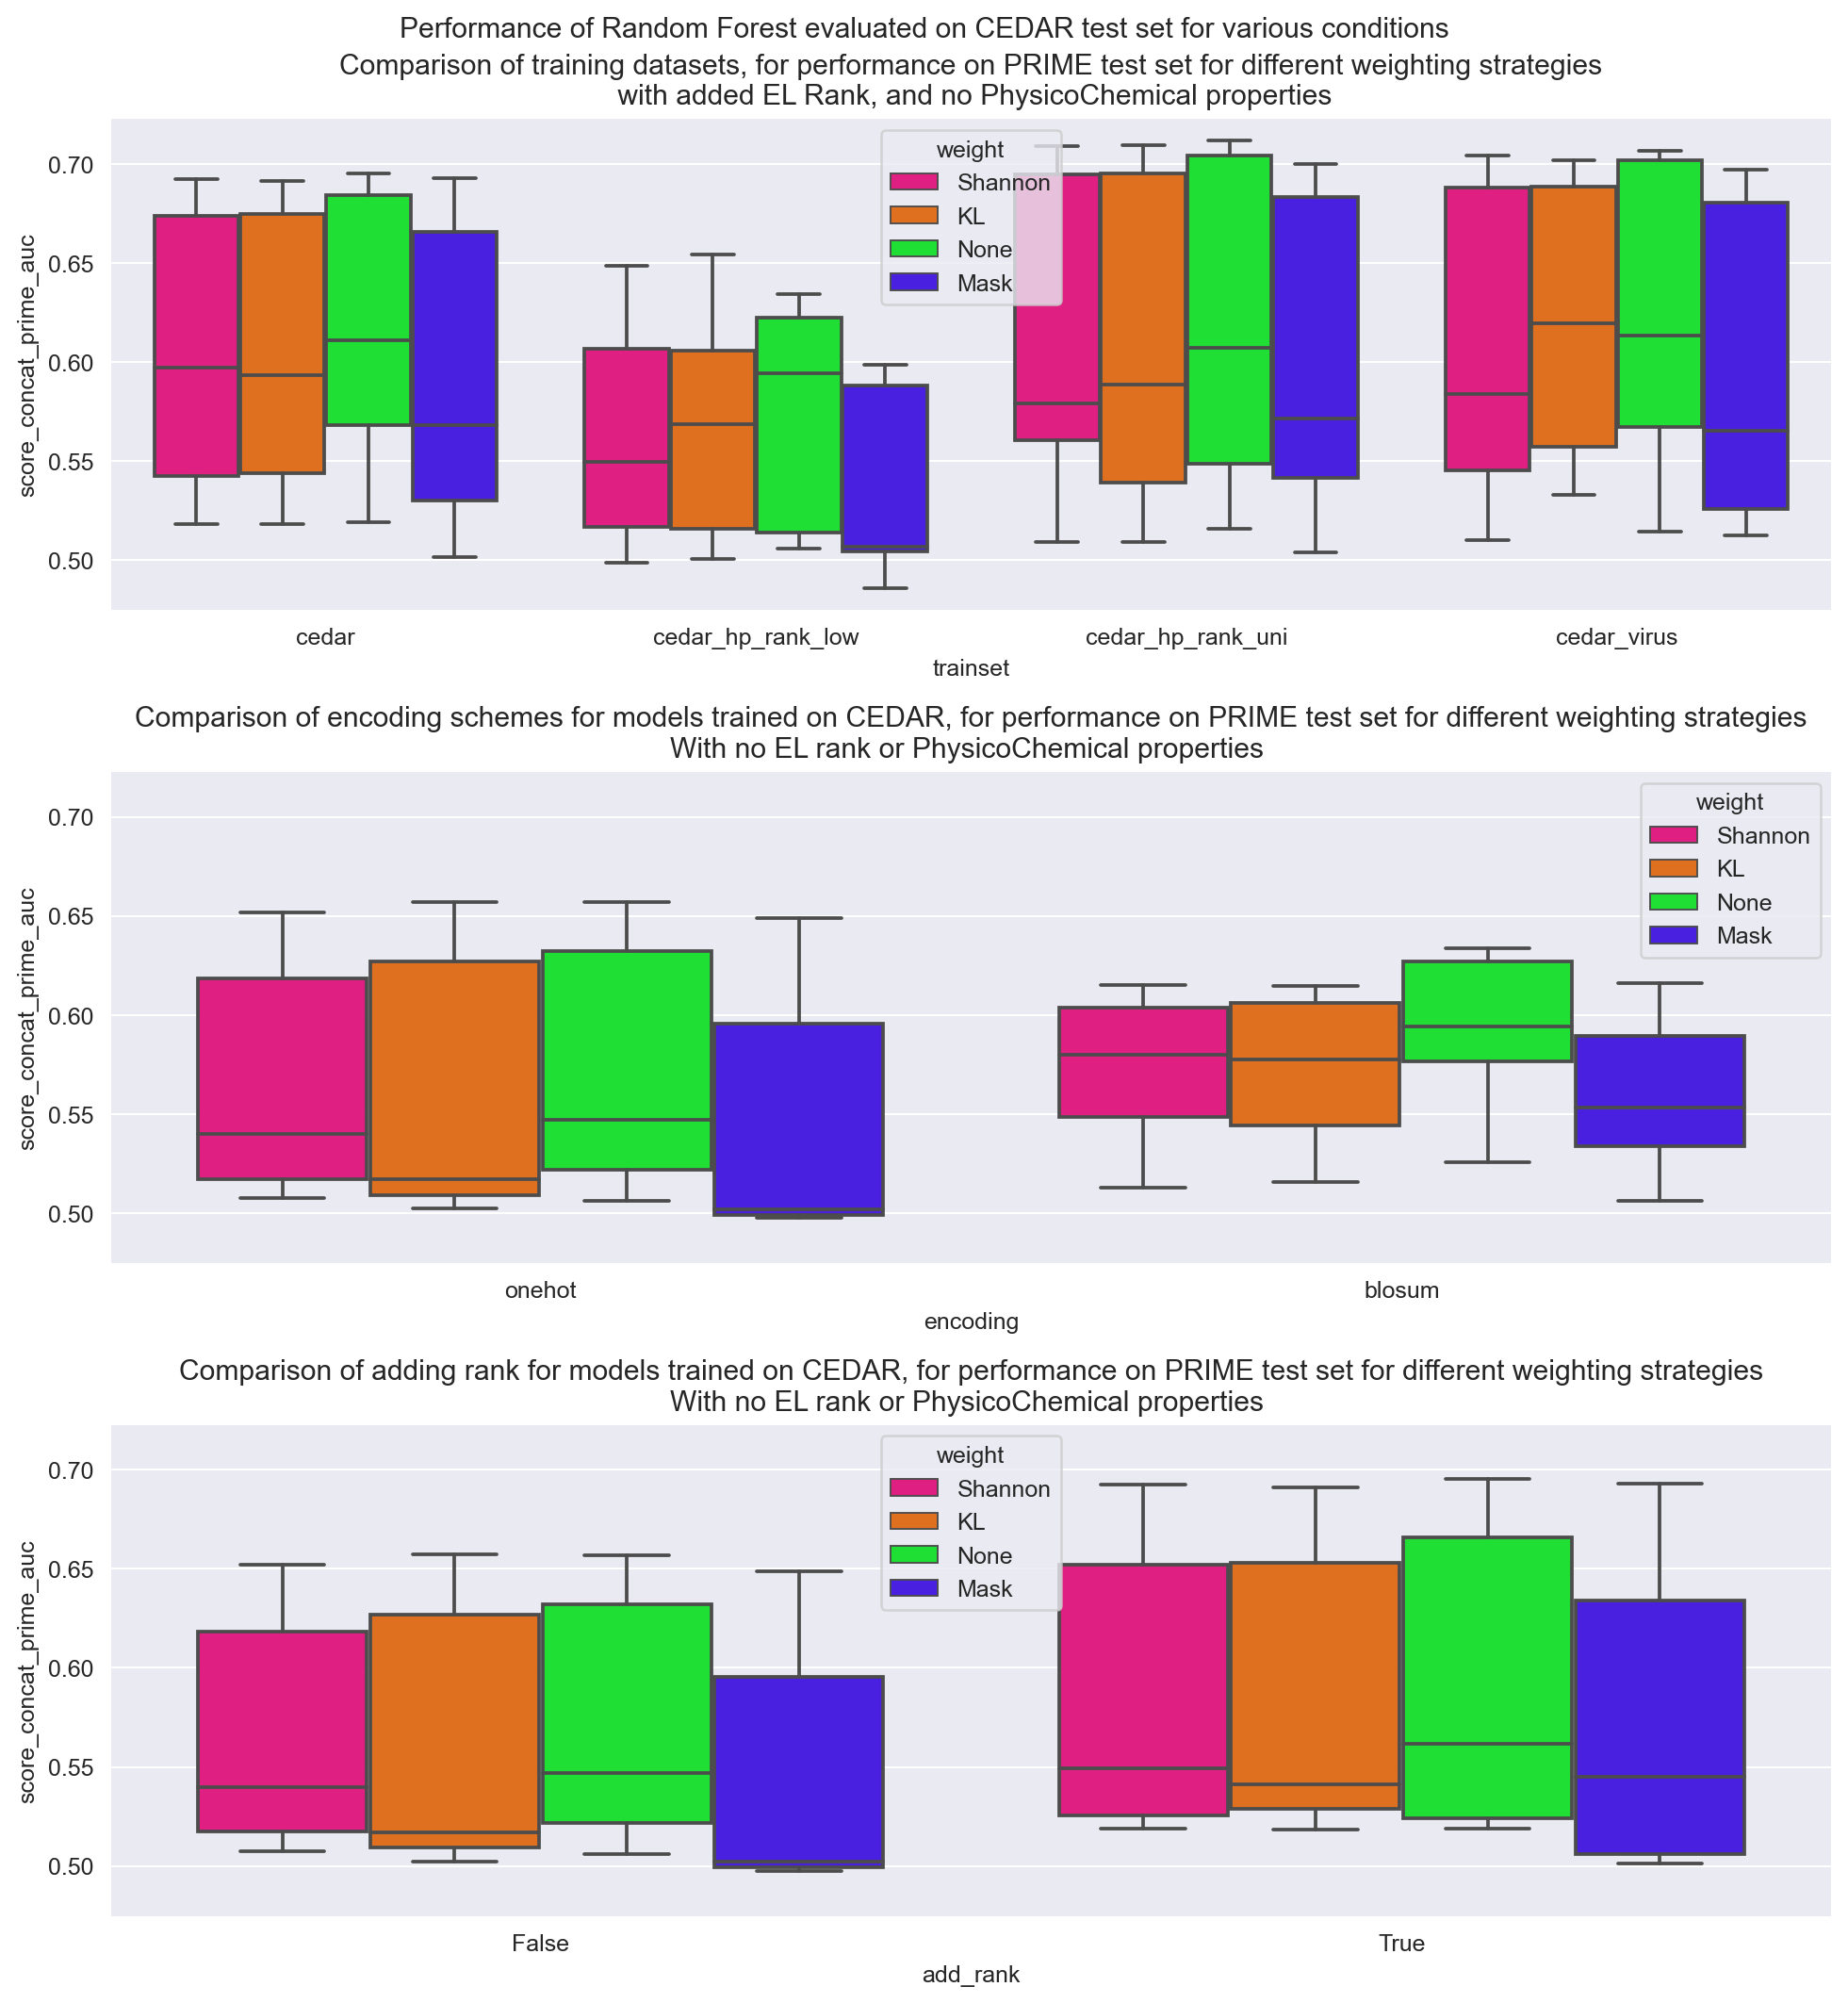

In [382]:
f,a = plt.subplots(3,1, figsize=(11,12), sharey=True)
PAL = sns.color_palette('hsv', n_colors=13)
palette = [PAL[-1], PAL[0], PAL[4], PAL [-4]]

f.suptitle('Performance of Random Forest evaluated on CEDAR test set for various conditions')
sns.set_palette(palette)
# 1
sns.boxplot(data=df_simple.query('add_rank==True and remove_pep==False and add_aaprop == False and standardize==True'),
            orient='v',x= 'trainset' , hue= 'weight', y = 'score_concat_prime_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[0])
a[0].set_title('Comparison of training datasets, for performance on PRIME test set for different weighting strategies\n with added EL Rank, and no PhysicoChemical properties')
# 2

sns.boxplot(data=df_simple.query('trainset=="cedar" and add_rank==False and add_aaprop==False and remove_pep==False and standardize==True'),
            orient='v', x='encoding', y = 'score_concat_prime_auc', hue = 'weight', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[1])
a[1].set_title('Comparison of encoding schemes for models trained on CEDAR, for performance on PRIME test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
# 
sns.boxplot(data=df_simple.query('trainset=="cedar" and encoding=="onehot" and add_aaprop ==False and remove_pep==False and standardize==True'),
            orient='v',
            x='add_rank', hue = 'weight', y='score_concat_prime_auc', hue_order = ['Shannon', 'KL', 'None', 'Mask'], ax = a[2])
a[2].set_title('Comparison of adding rank for models trained on CEDAR, for performance on PRIME test set for different weighting strategies\nWith no EL rank or PhysicoChemical properties ')
f.tight_layout()